## AXON TRACKING ANALYSIS NOTEBOOK
### Part 1: Loading the data 
Instructions: 
1. root_path  = Path ("ENTER FILE PATH FOR SCOPE EXPORTED CSV FILES HERE")
2. run the first cell - this will read all the csv files in each sub folder and preprocess it for analysis  

All Relevant CSV Files in Scope Data:   
branch_metrics.csv  
axon_summary_metrics.csv   
neuron_metrics.csv


In [1]:
import os
import pandas as pd
from pathlib import Path

# Root directory
root_path = Path("/mnt/ben-shalom_nas/raw_data/rbs_maxtwo_desktop/harddisk24tbvol1/FolicAcid_T4_02252025_SA/Folic_Acid_T4_02252025_SA_AxonTracking_CSVs/")

# This will store all the data
data_dict = {}

# Walk through each subfolder
for run_folder in root_path.iterdir():
    if run_folder.is_dir():
        # Extract run number from folder name (after last "_")
        parts = run_folder.name.split("_")
        # Only use run number if there are at least 3 parts and the last part is numeric
        if len(parts) >= 3 or not parts[-1].isdigit():
            run_number = parts[-1]
        else: 
            continue
        # Drop the first row of every folder
        run_data = {}
        # Path to csv folder
        csv_folder = run_folder / "csv"
        if csv_folder.exists():
            run_data = {}
            for file in csv_folder.glob("*.csv"):
                # Remove ".csv" from filename to use as key
                key_name = file.stem  # e.g., branch_metrics, axon_summary_metrics
                try:
                    run_data[key_name] = pd.read_csv(file, header = 1)
                    
                except Exception as e:
                    print(f"Error reading {file.name} in run {run_number}: {e}")
            data_dict[run_number] = run_data


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/ben-shalom_nas/raw_data/rbs_maxtwo_desktop/harddisk24tbvol1/FolicAcid_T4_02252025_SA/Folic_Acid_T4_02252025_SA_AxonTracking_CSVs'

In [85]:
# Extract and print all run numbers from data dictionary
all_run_numbers = list(data_dict.keys())
print(f"Data loaded for {len(all_run_numbers)} runs.")
print("Extracted run numbers:", all_run_numbers)

Data loaded for 28 runs.
Extracted run numbers: ['22', '17', '16', '21', '48', '53', '54', '58', '59', '63', '64', '123', '125', '130', '49', '139', '145', '150', '151', '201', '202', '129', '134', '135', '140', '144', '206', '207']


### various metrics you can define 'column name' as to generate plots such as: 

Branch Length  	
Branch Conduction Velocity	  
Conduction Velocity Fit	  
Latency From Initiation Site	  
Distance From Initiation Site	  
Total Number of Spikes	  
Neuron Firing Rate	  
ISI Violation Rate	  
Fisher Projection Distance	  
Silhouette Score	  
Mean Number Spikes per Config	  
Footprint Completeness  

### Use the Dropdown menu to generate custom plots     

In [86]:
import pandas as pd
import re
from ipywidgets import widgets, interact

def get_column_titles_from_second_row(data_dict):
    column_titles = set()
    for file_dict in data_dict.values():
        for df in file_dict.values():
            if len(df) > 1:  # Ensure there is a second row
                second_row = df.iloc[1]
                column_titles.update(second_row.index)
    return sorted(column_titles)

def search_column_across_runs(data_dict, column_name):
    results = []
    for run_num, file_dict in data_dict.items():
        # Extract numeric part of run_num
        numeric_run_num = int(re.search(r'\d+', run_num).group())
        for file_name, df in file_dict.items():
            if column_name in df.columns:
                for val in df[column_name].dropna():
                    results.append({
                        "run_number": numeric_run_num,  # Ensure numeric sorting
                        "file": file_name,
                        "value": val
                    })
    df = pd.DataFrame(results)
    df = df.sort_values(by='run_number').reset_index(drop=True)
    return df

# Extract column titles from the second row
column_titles = get_column_titles_from_second_row(data_dict)

# Create a dropdown widget for column selection
dropdown = widgets.Dropdown(
    options=column_titles,
    description='Column:',
    disabled=False,
)

# Function to display results based on dropdown selection
def display_results(column_name):
    global results_df  # Make results_df accessible globally
    if column_name:
        results_df = search_column_across_runs(data_dict, column_name)
        display(results_df)

# Use interact to link the dropdown with the display function
interact(display_results, column_name=dropdown)

interactive(children=(Dropdown(description='Column:', options=(' Longest Branch Length', 'Amplitude at Initiat…

<function __main__.display_results(column_name)>

### decrease jitter by editing this following line

sns.stripplot(
    x='run_number', y='value', data=results_df_cleaned,
    **jitter=0.05**
)

this will decrease the amount of clutter that each data point will take up, or you can increase it for each point to take up more space

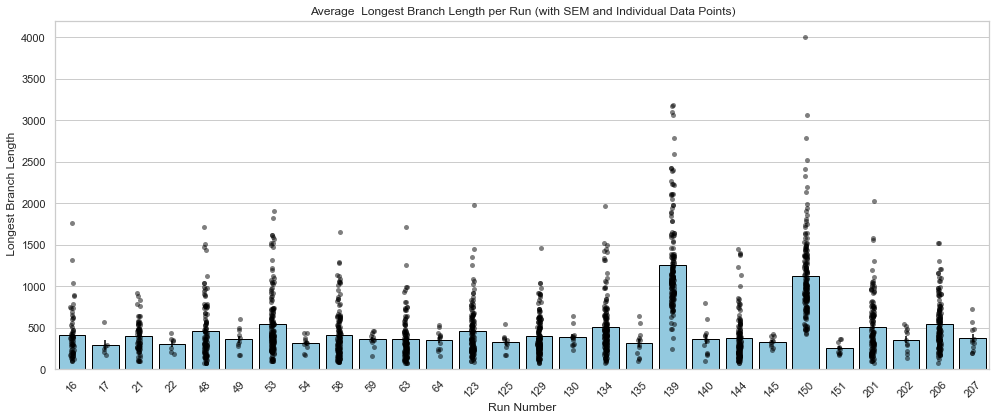

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure results_df is defined globally before running this cell
if 'results_df' not in globals():
    raise ValueError("Please select a column from the dropdown first to generate results_df.")

# Step 1: Clean up non-numeric rows
results_df_cleaned = results_df[pd.to_numeric(results_df['value'], errors='coerce').notnull()].copy()
results_df_cleaned['value'] = results_df_cleaned['value'].astype(float)

# Step 2: Compute average and standard error per run
summary_df = results_df_cleaned.groupby('run_number').agg(
    mean_value=('value', 'mean'),
    stderr_value=('value', lambda x: x.std(ddof=1) / np.sqrt(len(x)))
).reset_index()

# Step 3: Set up the plot
plt.figure(figsize=(14, 6))

# Bar plot with error bars
sns.barplot(
    x='run_number', y='mean_value', data=summary_df,
    yerr=summary_df['stderr_value'], capsize=0.2,
    color='skyblue', edgecolor='black'
)

# Dot plot of individual points (with jitter)
sns.stripplot(
    x='run_number', y='value', data=results_df_cleaned,
    color='black', alpha=0.5, jitter=0.05
)

# Final touches
plt.xlabel('Run Number')
plt.ylabel(dropdown.value)  # Use the selected column name dynamically
plt.title(f'Average {dropdown.value} per Run (with SEM and Individual Data Points)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Generates a bar plot, Box plot, Line plot, and density plot for the selected column from the dropdown menu

/tmp/ipykernel_2680730/2093153420.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(
/tmp/ipykernel_2680730/2093153420.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


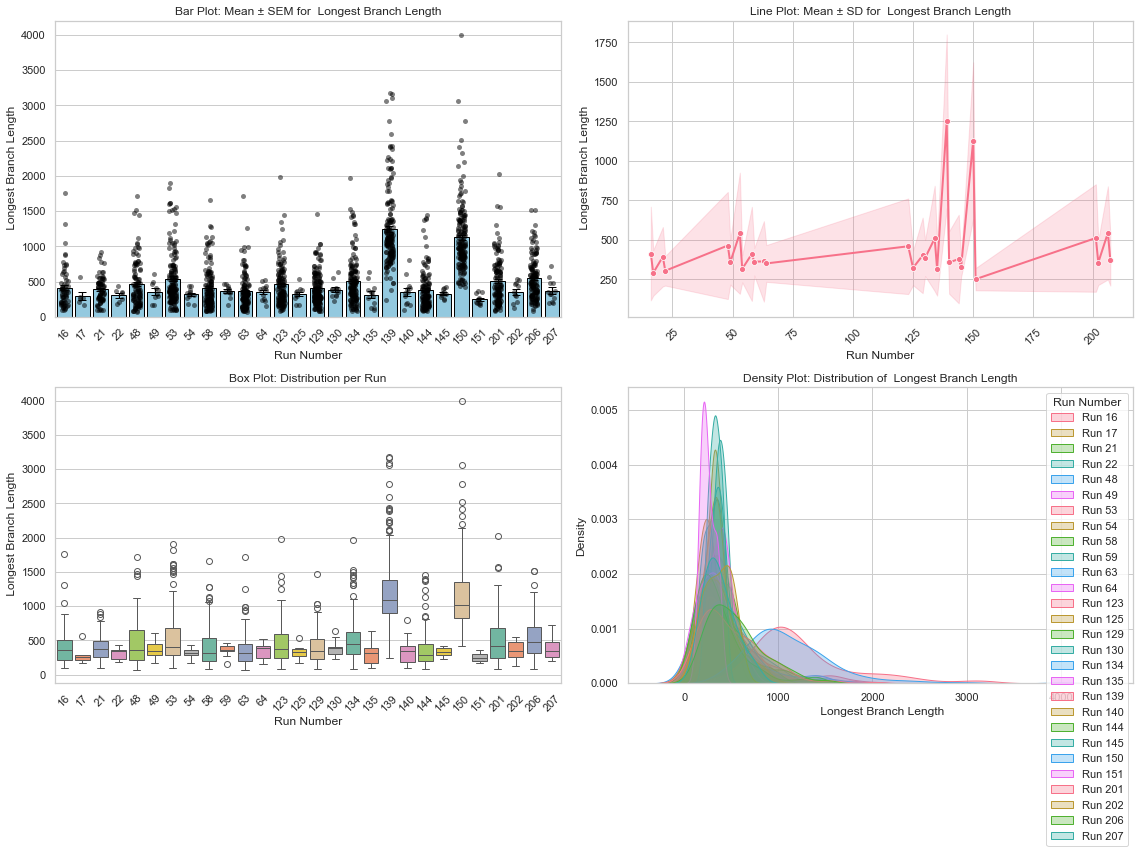

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure results_df_cleaned and summary_df exist
if 'results_df_cleaned' not in globals():
    # Clean up non-numeric rows
    results_df_cleaned = results_df[pd.to_numeric(results_df['value'], errors='coerce').notnull()].copy()
    results_df_cleaned['value'] = results_df_cleaned['value'].astype(float)

summary_df = results_df_cleaned.groupby('run_number').agg(
    mean_value=('value', 'mean'),
    stderr_value=('value', lambda x: x.std(ddof=1) / np.sqrt(len(x)))
).reset_index()

# Set a nice style
sns.set_theme(style="whitegrid", palette="husl")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# 1️⃣ Bar plot with error bars
sns.barplot(
    x='run_number', y='mean_value', data=summary_df,
    errorbar=('ci', 0),  # disables seaborn's own CI calculation
    ax=axes[0], color='skyblue', edgecolor='black'
)

# Add manual error bars using Matplotlib after plotting
axes[0].errorbar(
    x=np.arange(len(summary_df)),
    y=summary_df['mean_value'],
    yerr=summary_df['stderr_value'],
    fmt='none',
    ecolor='black',
    capsize=4,
    elinewidth=1.2,
)



axes[0].set_title(f'Bar Plot: Mean ± SEM for {dropdown.value}')
axes[0].set_xlabel('Run Number')
axes[0].set_ylabel(dropdown.value)
axes[0].tick_params(axis='x', rotation=45)

# Overlay stripplot for individual data
sns.stripplot(
    x='run_number', y='value', data=results_df_cleaned,
    color='black', alpha=0.5, jitter=0.2, ax=axes[0]
)

# 2️⃣ Line plot with markers (trend over runs)
sns.lineplot(
    x='run_number', y='value', data=results_df_cleaned,
    estimator='mean', ci='sd', marker='o', linewidth=2, ax=axes[1]
)
axes[1].set_title(f'Line Plot: Mean ± SD for {dropdown.value}')
axes[1].set_xlabel('Run Number')
axes[1].set_ylabel(dropdown.value)
axes[1].tick_params(axis='x', rotation=45)

# 3️⃣ Box plot for distribution per run
sns.boxplot(
    x='run_number', y='value', data=results_df_cleaned,
    ax=axes[2], palette="Set2"
)
axes[2].set_title(f'Box Plot: Distribution per Run')
axes[2].set_xlabel('Run Number')
axes[2].set_ylabel(dropdown.value)
axes[2].tick_params(axis='x', rotation=45)

# 4️⃣ KDE (density) plot — all runs overlaid
for run_num, subset in results_df_cleaned.groupby('run_number'):
    sns.kdeplot(subset['value'], label=f'Run {run_num}', fill=True, alpha=0.3, ax=axes[3])
axes[3].set_title(f'Density Plot: Distribution of {dropdown.value}')
axes[3].set_xlabel(dropdown.value)
axes[3].legend(title="Run Number")

plt.tight_layout()
plt.show()


### Load MetaData (Reference Sheet) for Comparative Analysis on various conditions

In [89]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import re


# Step 1: Load and filter the metadata from tracking sheet
def load_and_filter_metadata(metadata_file_path):
    """Load metadata and filter for Axon Tracking assays only"""
    metadata = pd.read_csv(metadata_file_path)  # Regular CSV format
    # Filter columns 0 to 6 (titles "Date" to "Neuron Source")
    metadata = metadata.iloc[:, 0:7]
    # Filter for Axon Tracking assays only
    axon_tracking_data = metadata[metadata['Assay'] == 'Axon Tracking 1hr'].copy()
    axon_tracking_data.head()

    # Create a mapping of run number to density/media info
    run_condition_map = {} 
    for _, row in axon_tracking_data.iterrows():
        wells = str(row['Wells_Recorded']).split(',')
        sources = str(row['Neuron Source']).split(',')
        
        # Ensure both lists are of the same length
        if len(wells) != len(sources):
            print(f"Warning: Mismatch in lengths for Run {row['Run #']}. Wells: {len(wells)}, Sources: {len(sources)}")
            continue
        
        # Map each well to its corresponding source
        well_source_map = {well.strip(): source.strip() for well, source in zip(wells, sources)}
        
        # Add to the run_condition_map
        run_condition_map[row['Run #']] = well_source_map
    
    # Convert the mapping to a DataFrame for better visualization
    run_condition_df = pd.DataFrame([
        {'Run #': run, 'Well': well, 'Neuron Source': source}
        for run, well_sources in run_condition_map.items()
        for well, source in well_sources.items()
    ])
    
    print(run_condition_df)
    return run_condition_df

# Load metadata
metadata_file_path = "/mnt/disk20tb/shruti/MaxTwo MEA Primary Neurons Assays(FolicAcid_T4_02252025_SA).csv"
run_condition_df = load_and_filter_metadata(metadata_file_path)



    Run # Well Neuron Source
0    16.0    1        A_Male
1    16.0    2        B_Male
2    16.0    3        D_Male
3    16.0    4      A_Female
4    16.0    5      B_Female
..    ...  ...           ...
79  206.0    2        E_Male
80  206.0    3        C_Male
81  206.0    4        C_Male
82  206.0    5        E_Male
83  206.0    6      E_Female

[84 rows x 3 columns]


In [ ]:
# import os
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from pathlib import Path
# import re


# SUPPOSED TO PLOT FROM REFERENCE SHEET 
# # Step 4: Plotting functions
# def plot_density_comparison(df, metric_name, plot_type='both'):
#     """Create plots comparing densities for a given metric"""
#     # Clean up non-numeric values
#     df_clean = df[pd.to_numeric(df['value'], errors='coerce').notnull()].copy()
#     df_clean['value'] = df_clean['value'].astype(float)
    
#     if df_clean.empty:
#         print(f"No valid data found for {metric_name}")
#         return
    
#     # Create density labels and order them from least to greatest
#     df_clean['density_label'] = df_clean['density'].astype(str) + 'K ' + df_clean['media']
    
#     # Create ordered categories based on density (numerical) then media (alphabetical)
#     density_order = df_clean.groupby('density_label')['density'].first().sort_values().index.tolist()
#     df_clean['density_label'] = pd.Categorical(df_clean['density_label'], categories=density_order, ordered=True)
    
#     plt.figure(figsize=(15, 10))
    
#     if plot_type in ['both', 'violin']:
#         plt.subplot(2, 2, 1)
#         sns.violinplot(data=df_clean, x='density_label', y='value', order=density_order)
#         plt.title(f'{metric_name} Distribution by Density')
#         plt.xticks(rotation=45)
    
#     if plot_type in ['both', 'box']:
#         plt.subplot(2, 2, 2)
#         sns.boxplot(data=df_clean, x='density_label', y='value', order=density_order)
#         plt.title(f'{metric_name} Box Plot by Density')
#         plt.xticks(rotation=45)
    
#     if plot_type in ['both', 'bar']:
#         plt.subplot(2, 2, 3)
#         summary_df = df_clean.groupby('density_label').agg(
#             mean_value=('value', 'mean'),
#             stderr_value=('value', lambda x: x.std(ddof=1) / np.sqrt(len(x)) if len(x) > 1 else 0)
#         ).reset_index()
        
#         # Reorder summary_df according to density_order
#         summary_df['density_label'] = pd.Categorical(summary_df['density_label'], categories=density_order, ordered=True)
#         summary_df = summary_df.sort_values('density_label').reset_index(drop=True)
        
#         # Create bar plot
#         bars = plt.bar(range(len(summary_df)), summary_df['mean_value'], 
#                       yerr=summary_df['stderr_value'], capsize=5,
#                       color='skyblue', edgecolor='black', alpha=0.7)
        
#         plt.xlabel('Density')
#         plt.ylabel(f'Mean {metric_name}')
#         plt.title(f'Mean {metric_name} by Density (±SEM)')
#         plt.xticks(range(len(summary_df)), summary_df['density_label'], rotation=45)
    
#     if plot_type in ['both', 'strip']:
#         plt.subplot(2, 2, 4)
#         sns.stripplot(data=df_clean, x='density_label', y='value', 
#                      alpha=0.7, jitter=0.3, size=4, order=density_order)
#         plt.title(f'Individual {metric_name} Values by Density')
#         plt.xticks(rotation=45)
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print summary statistics (ordered)
#     print(f"\nSummary Statistics for {metric_name}:")
#     print("-" * 50)
#     summary_stats = df_clean.groupby('density_label')['value'].agg([
#         'count', 'mean', 'std', 'min', 'max'
#     ]).round(3)
#     # Reorder by density
#     summary_stats = summary_stats.reindex(density_order)
#     print(summary_stats)

# # Step 5: Statistical analysis
# def statistical_analysis(df, metric_name):
#     """Perform statistical analysis comparing densities"""
#     try:
#         from scipy import stats
#     except ImportError:
#         print("scipy not available. Skipping statistical analysis.")
#         return
    
#     df_clean = df[pd.to_numeric(df['value'], errors='coerce').notnull()].copy()
#     df_clean['value'] = df_clean['value'].astype(float)
#     df_clean['density_label'] = df_clean['density'].astype(str) + 'K ' + df_clean['media']
    
#     # Order density labels from least to greatest
#     density_order = df_clean.groupby('density_label')['density'].first().sort_values().index.tolist()
#     df_clean['density_label'] = pd.Categorical(df_clean['density_label'], categories=density_order, ordered=True)
    
#     # Group data by density (in order)
#     groups = []
#     group_names = []
#     for density in density_order:
#         group_data = df_clean[df_clean['density_label'] == density]['value'].values
#         if len(group_data) > 0:
#             groups.append(group_data)
#             group_names.append(density)
    
#     if len(groups) > 2:
#         # ANOVA for multiple groups
#         f_stat, p_value = stats.f_oneway(*groups)
#         print(f"\nANOVA Results for {metric_name}:")
#         print(f"F-statistic: {f_stat:.4f}")
#         print(f"p-value: {p_value:.4f}")
        
#         if p_value < 0.05:
#             print("Significant difference found between groups!")
            
#             # Post-hoc pairwise comparisons
#             print("\nPairwise t-tests (Bonferroni corrected):")
#             n_comparisons = len(groups) * (len(groups) - 1) // 2
#             alpha_corrected = 0.05 / n_comparisons
            
#             for i in range(len(groups)):
#                 for j in range(i+1, len(groups)):
#                     t_stat, p_val = stats.ttest_ind(groups[i], groups[j])
#                     significant = "***" if p_val < alpha_corrected else ""
#                     print(f"{group_names[i]} vs {group_names[j]}: p = {p_val:.4f} {significant}")
#         else:
#             print("No significant differences found between groups.")
    
#     elif len(groups) == 2:
#         # t-test for two groups
#         t_stat, p_value = stats.ttest_ind(groups[0], groups[1])
#         print(f"\nt-test Results for {metric_name}:")
#         print(f"t-statistic: {t_stat:.4f}")
#         print(f"p-value: {p_value:.4f}")
#         print(f"Significant: {'Yes' if p_value < 0.05 else 'No'}")
#     else:
#         print(f"Not enough groups for statistical comparison (found {len(groups)} groups)")

# # Function to explore available metrics
# def explore_available_metrics(data_dict):
#     """Find all available column names across all files"""
#     all_columns = set()
#     for run_num, file_dict in data_dict.items():
#         for file_name, df in file_dict.items():
#             all_columns.update(df.columns)
    
#     print("Available metrics to analyze:")
#     for col in sorted(all_columns):
#         print(f"  - {col}")
    
#     return sorted(all_columns)

# # Main execution
# if __name__ == "__main__":
#     # Replace these paths with your actual file path
#     metadata_file_path = "/mnt/disk20tb/shruti/MaxTwo MEA Primary Neurons Assays(FolicAcid_T4_02252025_SA).csv"  # The tab-separated file you pasted
#     detailed_data_path = root_path

#     # Load data
#     print("Loading metadata...")
#     try:
#         run_density_map = load_and_filter_metadata(metadata_file_path)
#         print(f"Found {len(run_density_map)} axon tracking runs")
        
#         # Print the runs found for debugging
#         print("Axon tracking runs found:")
#         for run_num, info in run_density_map.items():
#             print(f"  Run {run_num}: {len(info['wells'])} wells")
#             for well, well_info in info['wells'].items():
#                 print(f"    Well {well}: {well_info['density']}K {well_info['media']}")
    
#     except Exception as e:
#         print(f"Error loading metadata: {e}")
#         run_density_map = {}

#     print("\nLoading detailed data...")
#     try:
#         data_dict = load_detailed_data(detailed_data_path)
#         print(f"Loaded data for {len(data_dict)} runs")
        
#         # Print which runs have data
#         print("Runs with detailed data:", sorted(data_dict.keys()))
        
#     except Exception as e:
#         print(f"Error loading detailed data: {e}")
#         data_dict = {}

#     # Check for overlap between metadata and detailed data
#     if run_density_map and data_dict:
#         metadata_runs = set(run_density_map.keys())
#         detailed_runs = set(data_dict.keys())
#         overlap = metadata_runs.intersection(detailed_runs)
#         print(f"\nRuns with both metadata and detailed data: {sorted(overlap)}")
        
#         if not overlap:
#             print("WARNING: No overlap between metadata runs and detailed data runs!")
#             print(f"Metadata runs: {sorted(metadata_runs)}")
#             print(f"Detailed data runs: {sorted(detailed_runs)}")

#     # Uncomment to see all available metrics:
#     if data_dict:
#         print("\n" + "="*60)
#         available_metrics = explore_available_metrics(data_dict)
#         print("="*60)

#     # Analyze different metrics
#     metrics_to_analyze = ['branchLen', 'neuronFiringRate', 'branchConductionVel', 'totNoSpikes']

#     for metric in metrics_to_analyze:
#         print(f"\n{'='*60}")
#         print(f"Analyzing {metric}")
#         print('='*60)
        
#         # Get data with density information
#         results_df = search_column_with_density(data_dict, run_density_map, metric)
        
#         if not results_df.empty:
#             print(f"Found {len(results_df)} data points for {metric}")
            
#             # Print unique density combinations found
#             unique_densities = results_df.groupby(['density', 'media']).size().reset_index(name='count')
#             print("Density combinations found:")
#             for _, row in unique_densities.iterrows():
#                 print(f"  {row['density']}K {row['media']}: {row['count']} data points")
            
#             # Create plots
#             plot_density_comparison(results_df, metric)
            
#             # Statistical analysis
#             statistical_analysis(results_df, metric)
#         else:
#             print(f"No data found for {metric}")
            
#             # Debug: check if column exists anywhere
#             found_in_files = []
#             for run_num, file_dict in data_dict.items():
#                 for file_name, df in file_dict.items():
#                     if metric in df.columns:
#                         found_in_files.append(f"Run {run_num}, file {file_name}")
            
#             if found_in_files:
#                 print(f"  But {metric} was found in: {found_in_files}")
#             else:
#                 print(f"  {metric} not found in any files.")

## AXONAL AREA

In [ ]:
''' First Cell: Single Axonal Area Calculation from PNG Image
    Input: PNG image file path - ENTER PNG FILE PATH after image_path =
    Output: Axon-covered area in µm²'''
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load your PNG file
image_path = "/mnt/ben-shalom_nas/raw_data/rbs_maxtwo_desktop/harddisk24tbvol1/Media_Density_T3_07012025_AR/Media_Density_T3_07012025_AR/250717/M07137/AxonTracking/000148/analysis/FootprintExtraction_v1/0001/Well4/FootprintNeuron#16.png"  # Replace with the actual path
img = Image.open(image_path).convert("RGB")

# Convert image to numpy array
img_np = np.array(img)

# Convert to grayscale using luminance formula
gray_img = np.dot(img_np[...,:3], [0.2989, 0.5870, 0.1140])

# Apply a grayscale threshold to isolate the signal (tweak this threshold as needed)
threshold = 30  # Adjust if needed
axon_mask = gray_img > threshold

# Estimate pixel size from scale bar: 100 µm ≈ 18 pixels → 1 pixel ≈ 5.56 µm
pixel_size_um = 100 / 18
pixel_area_um2 = pixel_size_um ** 2

# Calculate axonal area
axon_area_um2 = np.sum(axon_mask) * pixel_area_um2

# Output results
print(f"Axon-covered area: {axon_area_um2:.2f} µm²")


Axon-covered area: 748858.02 µm²


BASE_DIR = FILE PATH TO RAW_DATA FOLDER   
OUTPUT_DIR = ENTER FILE PATH TO FOLDER YOU WANT YOUR RESULTS TO BE IN

This saves a csv file labeled axon_area_results.csv to the desired output folder, which calculates all neurons axon area (amuont of space the axon is taking up in a singular footprint)

In [91]:
import os
import re
from PIL import Image
import numpy as np
import csv

# CONFIGURATION
BASE_DIR = "/mnt/ben-shalom_nas/raw_data/rbs_maxtwo_desktop/harddisk24tbvol1/FolicAcid_T4_02252025_SA/FolicAcid_T4_02252025_SA/"
OUTPUT_DIR = "/mnt/disk20tb/shruti/AxonTracking?_NeedsOrganizing/"
OUTPUT_CSV = "axon_area_results.csv"
PIXELS_PER_100_UM = 18  # from scale bar
PIXEL_AREA_UM2 = (100 / PIXELS_PER_100_UM) ** 2  # µm² per pixel
THRESHOLD = 30  # grayscale or red channel threshold (adjust as needed)

def is_target_image(filename):
    return re.match(r"FootprintNeuron#\d+\.png", filename)

def extract_metadata(filepath):
    """
    Extract Plate ID, AxonTracking ID, Well number, Neuron number from the path
    """
    parts = filepath.split(os.sep)
    try:
        plate_id = next(p for p in parts if p.startswith("M"))
        tracking_id = parts[parts.index("AxonTracking") + 1]
        well_match = re.search(r"Well(\d+)", filepath)
        neuron_match = re.search(r"FootprintNeuron#(\d+)", filepath)
        return {
            "plate_id": plate_id,
            "tracking_id": tracking_id,
            "well": f"Well{well_match.group(1)}" if well_match else "Unknown",
            "neuron": f"Neuron#{neuron_match.group(1)}" if neuron_match else "Unknown"
        }
    except Exception:
        return {"plate_id": "Unknown", "tracking_id": "Unknown", "well": "Unknown", "neuron": "Unknown"}

def analyze_image(image_path, threshold=THRESHOLD):
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)

    # Use red channel as signal indicator (red = high µV in colormap)
    red_channel = img_np[:, :, 0]

    # Apply threshold
    signal_mask = red_channel > threshold
    pixel_count = np.sum(signal_mask)
    area_um2 = pixel_count * PIXEL_AREA_UM2

    return area_um2, pixel_count

def main():
    results = []

    for root, _, files in os.walk(BASE_DIR):
        for file in files:
            if is_target_image(file):
                full_path = os.path.join(root, file)
                metadata = extract_metadata(full_path)
                area_um2, pixel_count = analyze_image(full_path)

                results.append({
                    "Plate ID": metadata["plate_id"],
                    "Tracking ID": metadata["tracking_id"],
                    "Well": metadata["well"],
                    "Neuron": metadata["neuron"],
                    "Pixel Count": pixel_count,
                    "Axon Area (µm²)": round(area_um2, 2),
                    "Threshold Used": THRESHOLD
                })
                #print(results)

    # Output nicely
    print("\n📊 Axon Area Analysis Results:\n")
    #for r in results:
        #print(f"{r['Plate ID']} | {r['Tracking ID']} | {r['Well']} | {r['Neuron']}: {r['Axon Area (µm²)']} µm² (Pixels: {r['Pixel Count']})")

    # Save to CSV
    with open(OUTPUT_DIR + "/" + OUTPUT_CSV, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=results[0].keys())
        writer.writeheader()
        writer.writerows(results)

    print(f"\n✅ Results saved to {OUTPUT_DIR + OUTPUT_CSV}")

if __name__ == "__main__":
    main()



📊 Axon Area Analysis Results:


✅ Results saved to /mnt/disk20tb/shruti/AxonTracking?_NeedsOrganizing/axon_area_results.csv


#### Plotting for Axonal Area Per Run, Per Neuron, Per Well - Color coded

/tmp/ipykernel_2680730/3169016442.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Neuron", y="Axon Area (µm²)", hue="Well", data=df, ci = None)


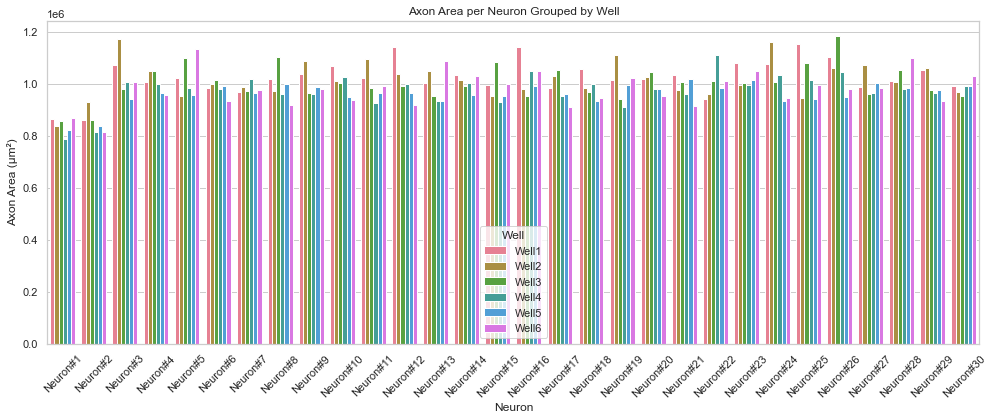

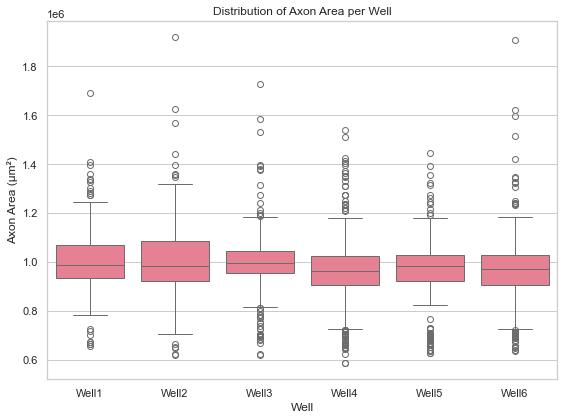

In [93]:
'''TEST ON ONE RUN'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV
df = pd.read_csv("axon_area_results.csv")  # Update path if needed

# Optional: sort for better viultssuals
df["Neuron ID"] = df["Neuron"].str.extract(r'#(\d+)').astype(int)
df = df.sort_values(["Well", "Neuron ID"])

# Plot 1: Bar Plot per Neuron (grouped by Well)
plt.figure(figsize=(14, 6))
sns.barplot(x="Neuron", y="Axon Area (µm²)", hue="Well", data=df, ci = None)
plt.title("Axon Area per Neuron Grouped by Well")
plt.ylabel("Axon Area (µm²)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Box Plot per Well
plt.figure(figsize=(8, 6))
sns.boxplot(x="Well", y="Axon Area (µm²)", data=df)
plt.title("Distribution of Axon Area per Well")
plt.ylabel("Axon Area (µm²)")
plt.tight_layout()
plt.show()


### Barplot and Scatter Plot the Axon Area across all runs per neuron per well 


📊 Plotting Tracking ID: 16


/tmp/ipykernel_2680730/983960365.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


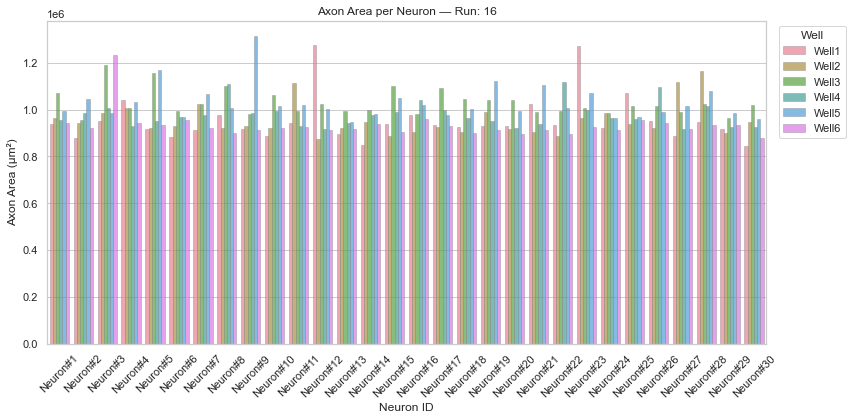

/tmp/ipykernel_2680730/983960365.py:40: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


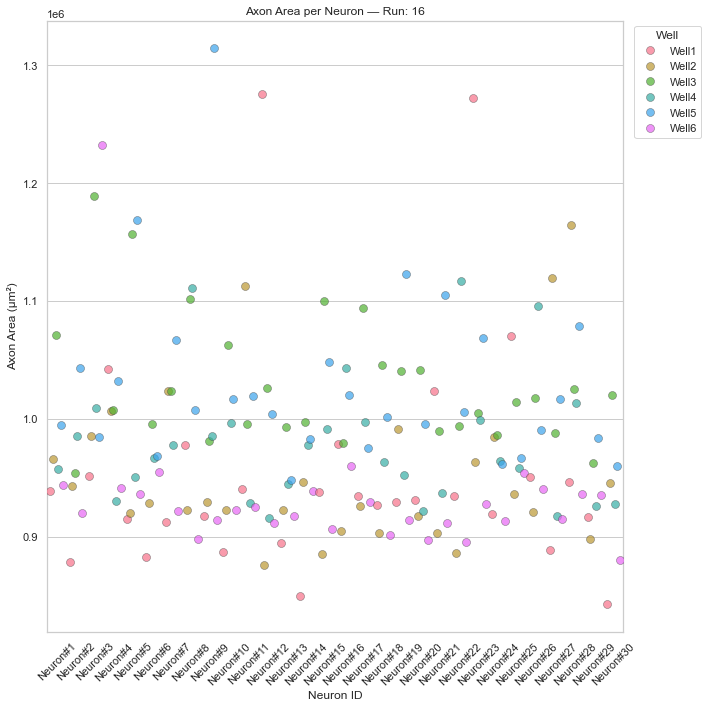


📊 Plotting Tracking ID: 17


/tmp/ipykernel_2680730/983960365.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


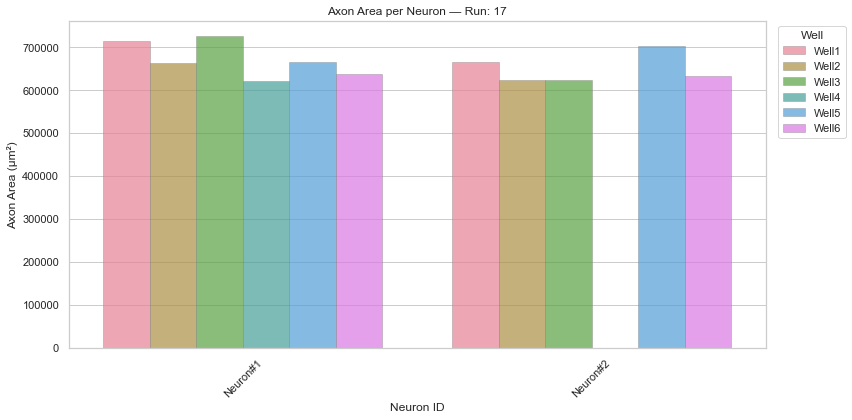

/tmp/ipykernel_2680730/983960365.py:40: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


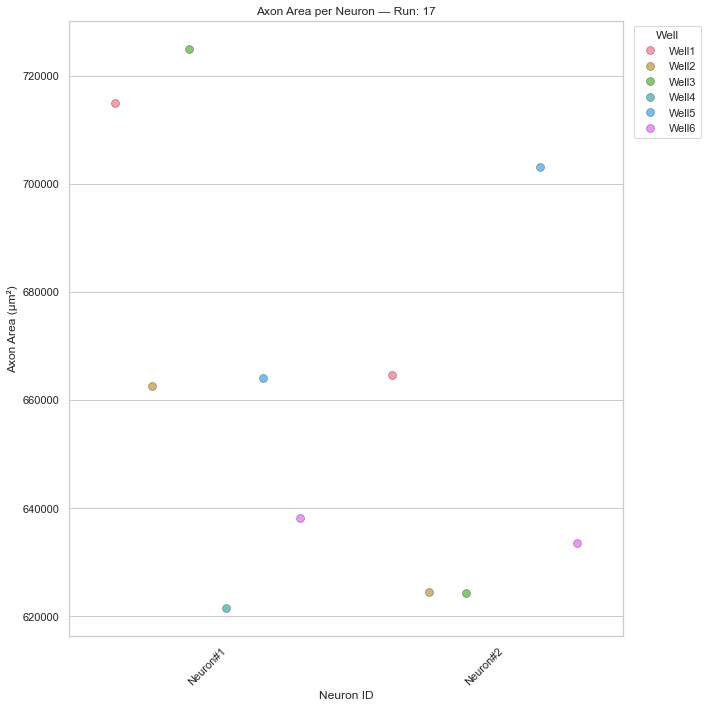


📊 Plotting Tracking ID: 21


/tmp/ipykernel_2680730/983960365.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


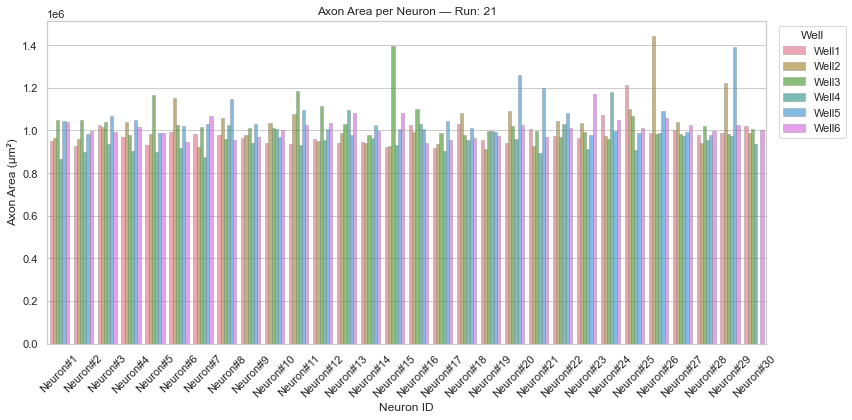

/tmp/ipykernel_2680730/983960365.py:40: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


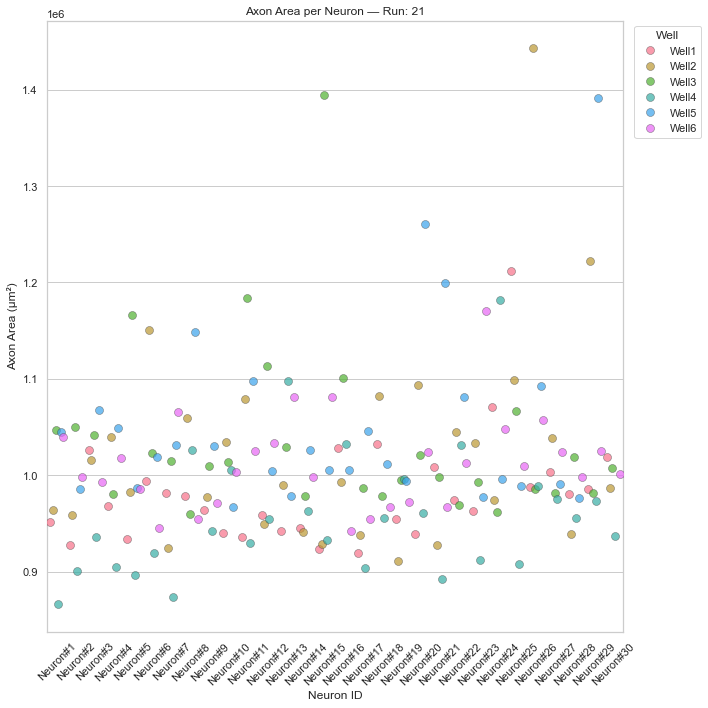


📊 Plotting Tracking ID: 22


/tmp/ipykernel_2680730/983960365.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


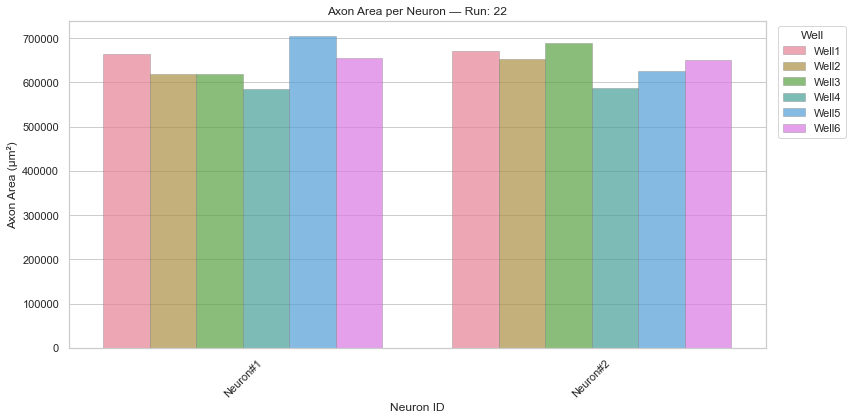

/tmp/ipykernel_2680730/983960365.py:40: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


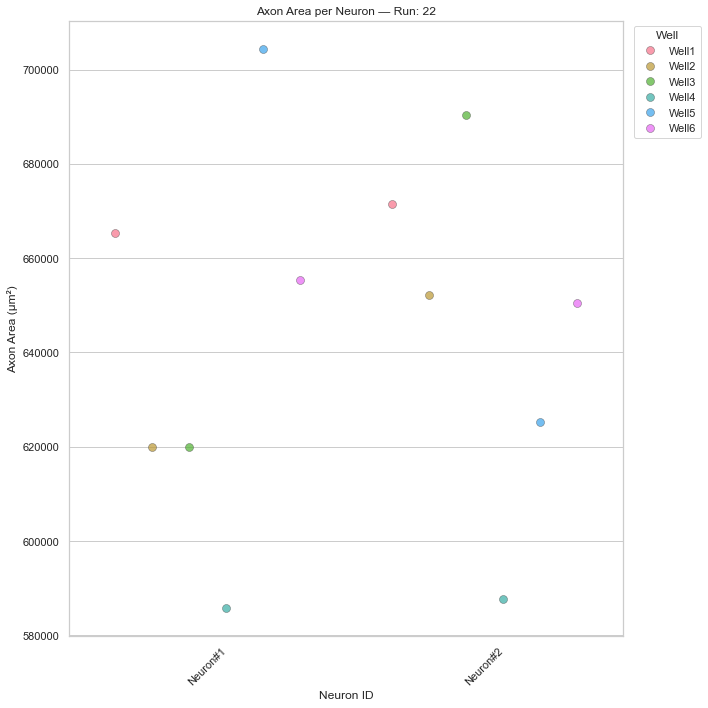


📊 Plotting Tracking ID: 48


/tmp/ipykernel_2680730/983960365.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


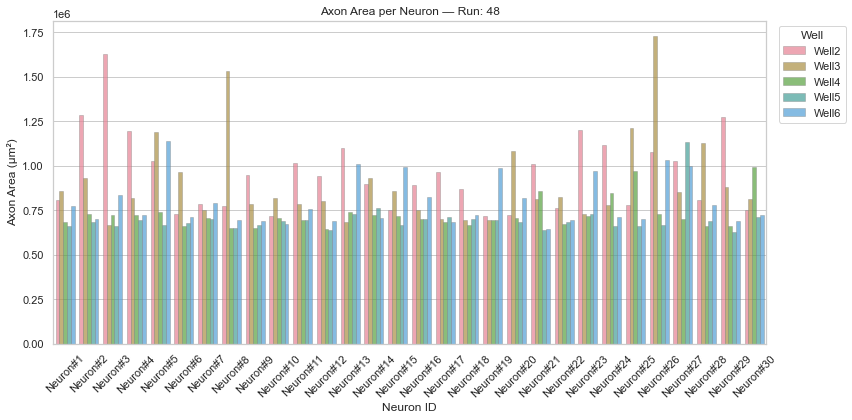

/tmp/ipykernel_2680730/983960365.py:40: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


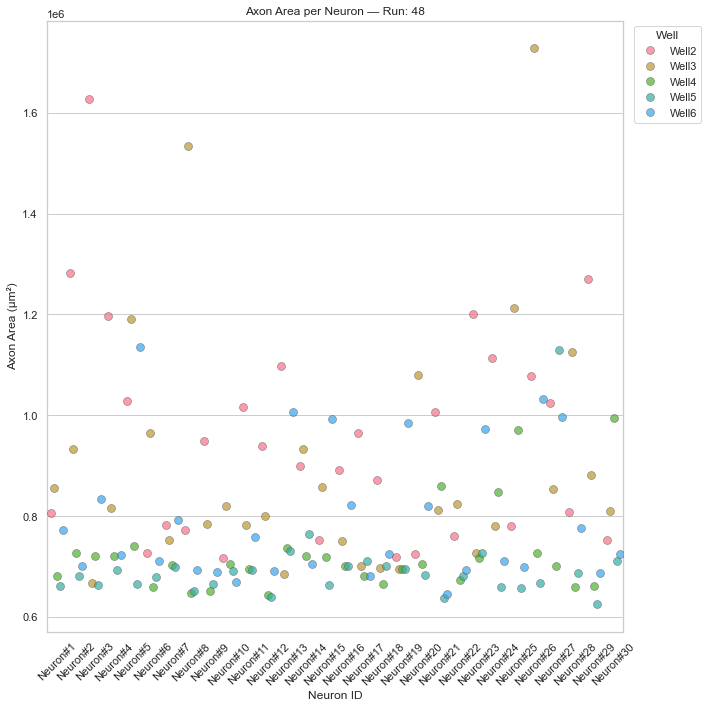


📊 Plotting Tracking ID: 49


/tmp/ipykernel_2680730/983960365.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


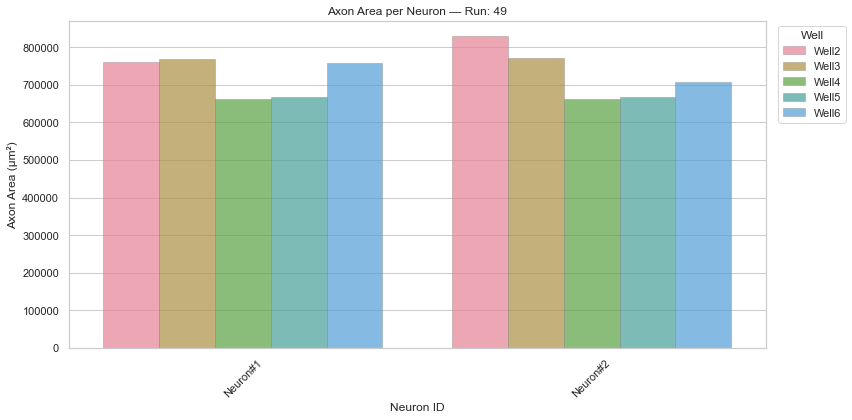

/tmp/ipykernel_2680730/983960365.py:40: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


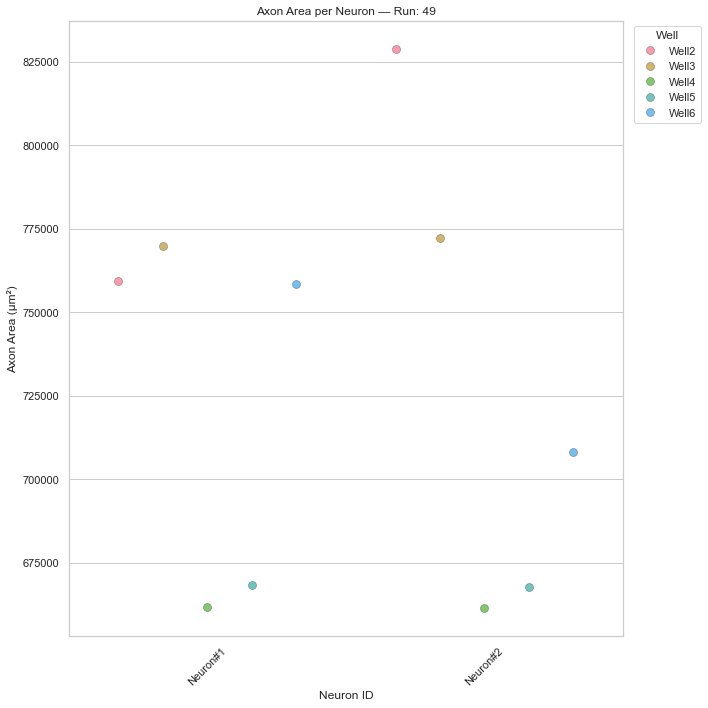


📊 Plotting Tracking ID: 53


/tmp/ipykernel_2680730/983960365.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


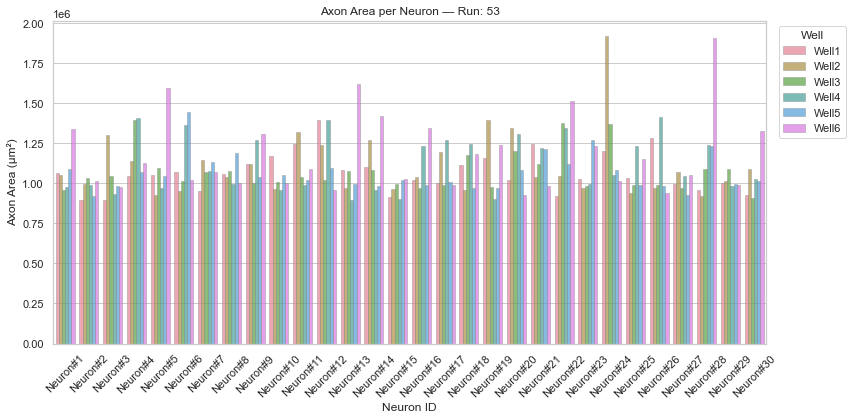

/tmp/ipykernel_2680730/983960365.py:40: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


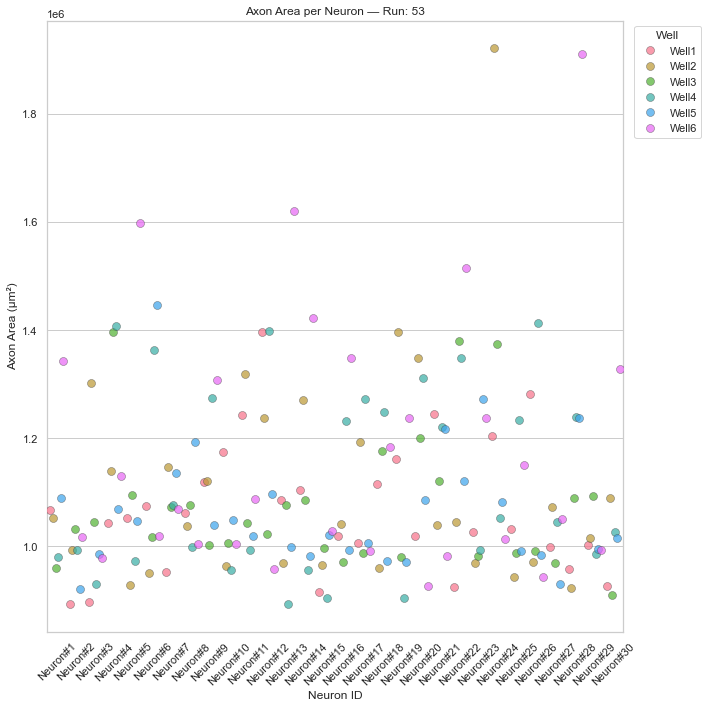


📊 Plotting Tracking ID: 54


/tmp/ipykernel_2680730/983960365.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


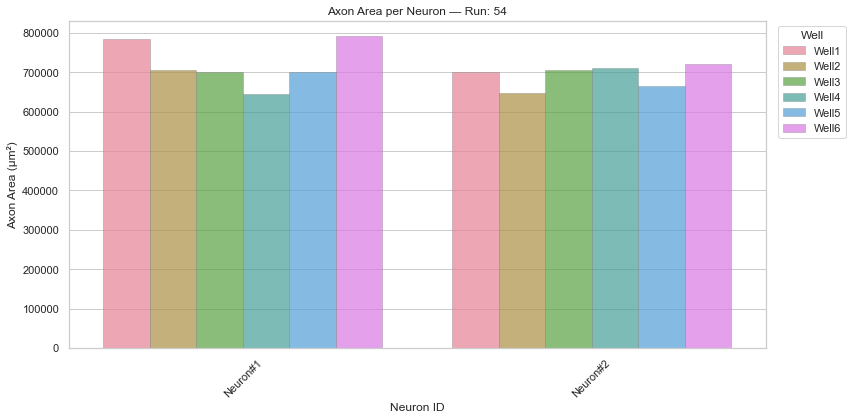

/tmp/ipykernel_2680730/983960365.py:40: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


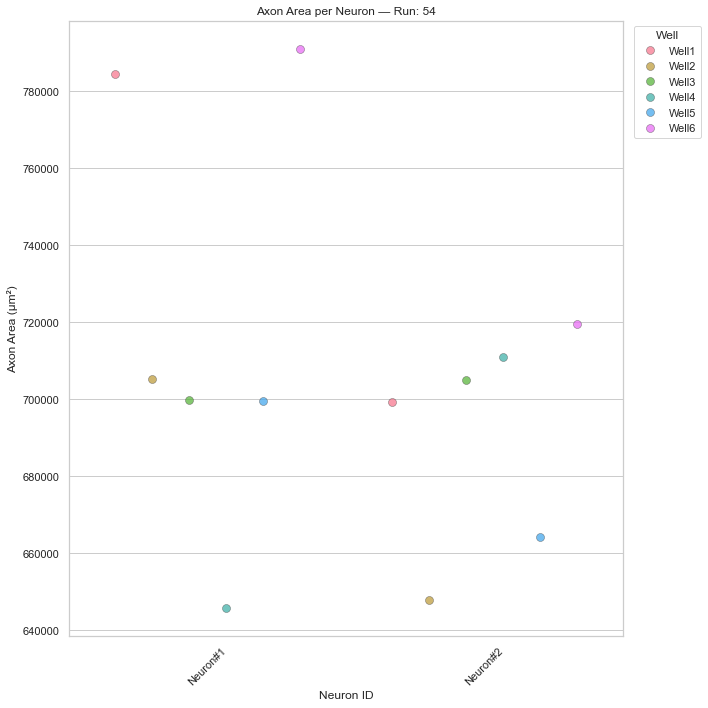


📊 Plotting Tracking ID: 58


/tmp/ipykernel_2680730/983960365.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


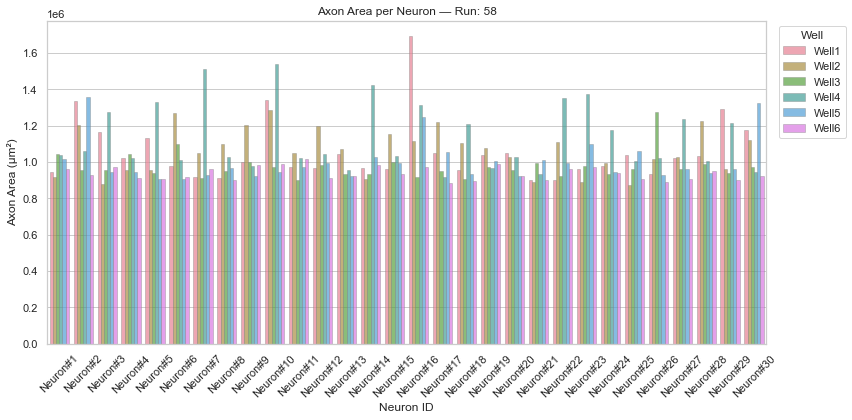

/tmp/ipykernel_2680730/983960365.py:40: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


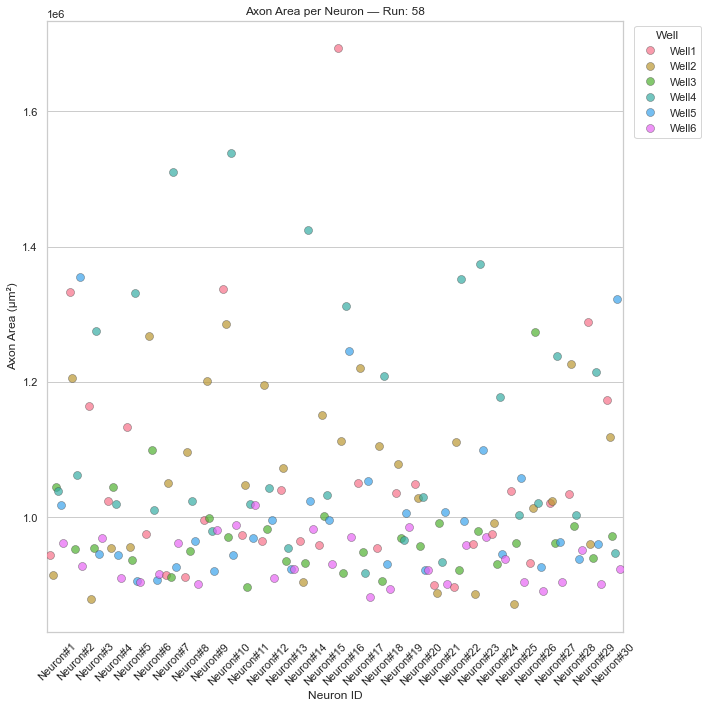


📊 Plotting Tracking ID: 59


/tmp/ipykernel_2680730/983960365.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


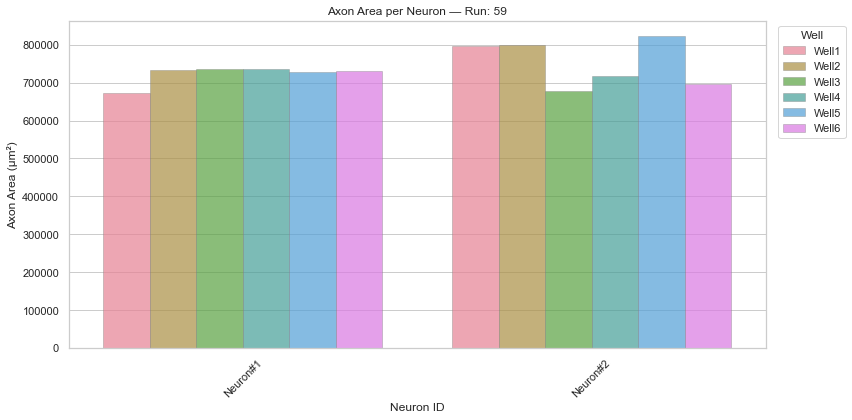

/tmp/ipykernel_2680730/983960365.py:40: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


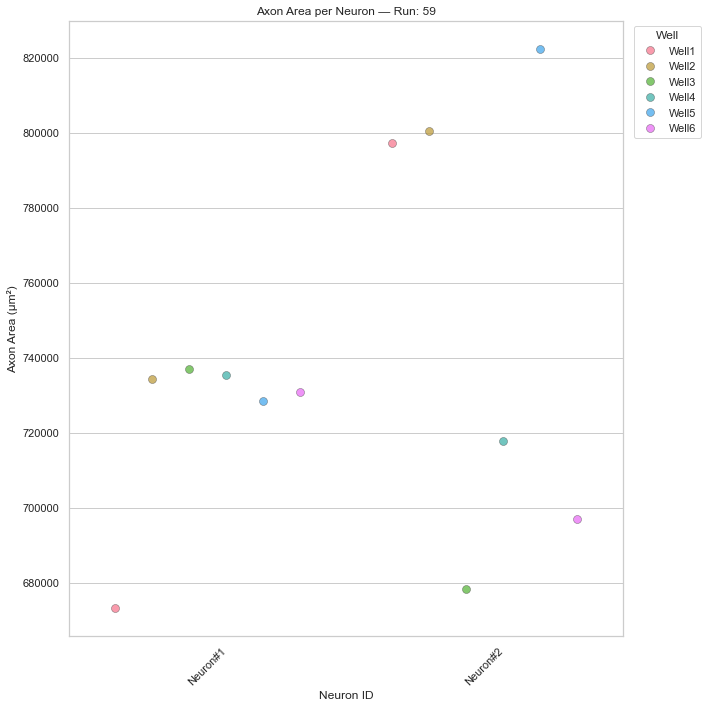


📊 Plotting Tracking ID: 63


/tmp/ipykernel_2680730/983960365.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


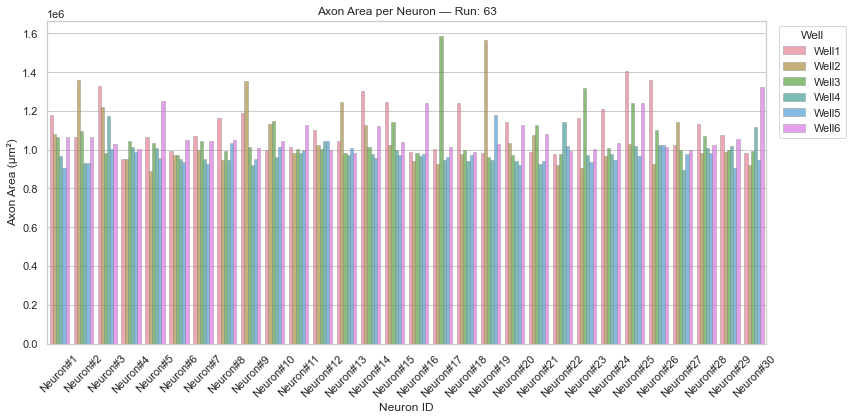

/tmp/ipykernel_2680730/983960365.py:40: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


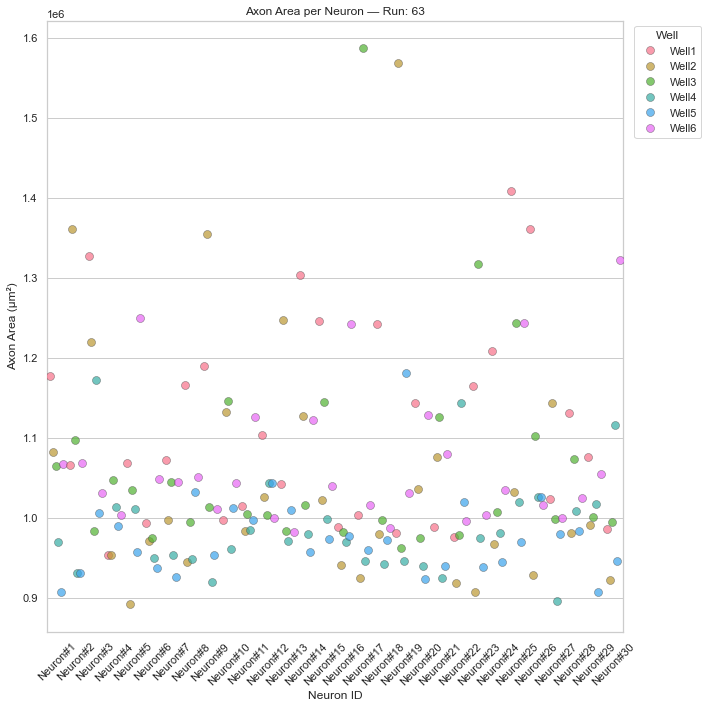


📊 Plotting Tracking ID: 64


/tmp/ipykernel_2680730/983960365.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


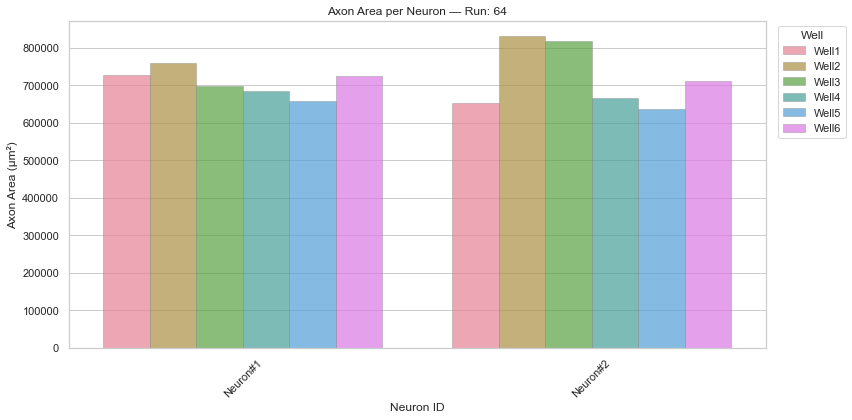

/tmp/ipykernel_2680730/983960365.py:40: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


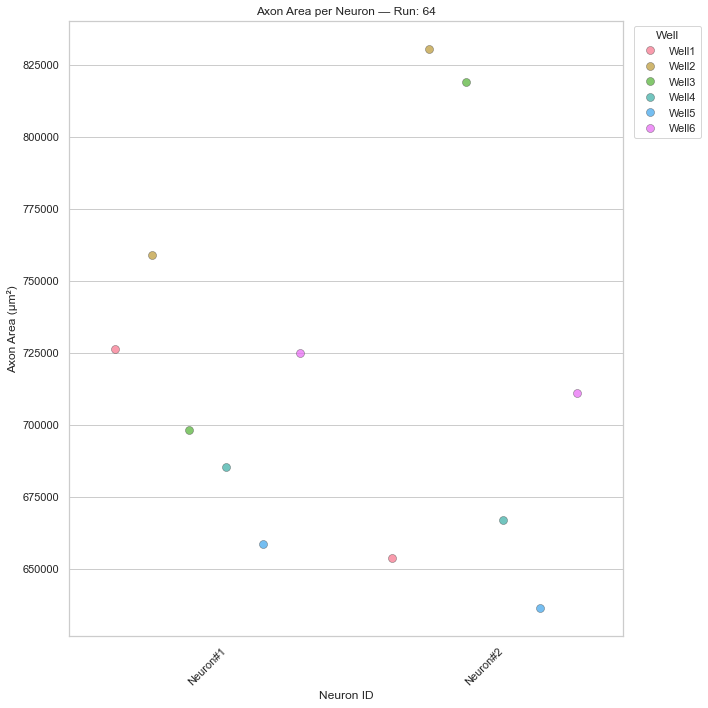

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
df = pd.read_csv("axon_area_results.csv")

# Extract Neuron ID number for sorting
df["Neuron ID"] = df["Neuron"].str.extract(r'#(\d+)').astype(int)

# Sort for consistency
df = df.sort_values(["Tracking ID", "Well", "Neuron ID"])

# Group by run (Tracking ID)
for tracking_id, run_df in df.groupby("Tracking ID"):
    print(f"\n📊 Plotting Tracking ID: {tracking_id}")

    plt.figure(figsize=(12, 6))
    sns.barplot(
        x = "Neuron",
        y="Axon Area (µm²)",
        hue="Well",
        data=run_df,
        ci=None,
        dodge=True, 
        alpha=0.7,
        edgecolor="gray",
        linewidth=0.5
    )

    plt.title(f"Axon Area per Neuron — Run: {tracking_id}")
    plt.xlabel("Neuron ID")
    plt.ylabel("Axon Area (µm²)")
    plt.xticks(rotation=45)
    plt.legend(title="Well", bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 10))
    sns.stripplot(
        x="Neuron",
        y="Axon Area (µm²)",
        hue="Well",
        data=run_df,
        dodge=True,
        jitter=True,
        alpha=0.7,
        size=8,
        edgecolor="gray",
        linewidth=0.5 

    )
    # plt.figure(figsize=(10, 6))
    # # Violinplot
    # sns.violinplot(data=run_df, x='Neuron ID', y='Axon Area (µm²)', palette='viridis', legend = True)
    # plt.title('Violinplot')
    # plt.show()

   
    plt.title(f"Axon Area per Neuron — Run: {tracking_id}")
    plt.xlabel("Neuron ID")
    plt.ylabel("Axon Area (µm²)")
    plt.xticks(rotation=45)
    plt.legend(title="Well", bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


In [95]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the PNG
image_path = "/mnt/ben-shalom_nas/raw_data/rbs_maxtwo_desktop/harddisk24tbvol1/Media_Density_T3_07012025_AR/Media_Density_T3_07012025_AR/250714/M07137/AxonTracking/000103/analysis/FootprintExtraction_v1/0001/Well3/FootprintNeuron#14.png"  # Replace with the actual path  # Change to your path
img = Image.open(image_path).convert("RGB")
img_np = np.array(img)

# Convert to grayscale
gray_img = np.dot(img_np[..., :3], [0.2989, 0.5870, 0.1140])

# Threshold to detect signal (axon area)
threshold = 30
axon_mask = gray_img > threshold

# Estimate pixel size and area
pixels_per_100um = 18
pixel_area_um2 = (100 / pixels_per_100um) ** 2
axon_area_um2 = np.sum(axon_mask) * pixel_area_um2

print(f"Estimated axon-covered area: {axon_area_um2:.2f} µm²")

# 🔽 Save visualization of axon detection
plt.figure(figsize=(6, 6))
plt.imshow(gray_img, cmap='gray')  # grayscale background
plt.imshow(axon_mask, cmap='Reds', alpha=0.5)  # red overlay for detected axon
plt.axis('off')
plt.title("Detected Axon Region")
plt.tight_layout()
plt.savefig(OUTPUT_DIR + "axon_detection_overlay.png", dpi=300)
plt.close()

print("✅ Saved axon detection overlay as 'axon_detection_overlay.png'")


Estimated axon-covered area: 1529969.14 µm²
✅ Saved axon detection overlay as 'axon_detection_overlay.png'


### Detection Rate per well

In [96]:
DETECTION_THRESHOLD_UM2 = 800_000  # Any footprint area above this = "Detected"
import pandas as pd

# Load existing analysis
df = pd.read_csv("axon_area_results.csv")

# Set your detection threshold
DETECTION_THRESHOLD_UM2 = 800_000

# Add detection status
df["Detected"] = df["Axon Area (µm²)"] >= DETECTION_THRESHOLD_UM2

# Organize data
df["Neuron ID"] = df["Neuron"].str.extract(r"#(\d+)").astype(int)
df = df.sort_values(["Well", "Neuron ID"])

# ✅ Save full detection DataFrame
df.to_csv("axon_detection_classified.csv", index=False)

# 📊 Detection summary per Well
summary = df.groupby("Well")["Detected"].sum().reset_index()
summary.columns = ["Well", "Neurons Detected"]
summary["Total Neurons"] = df.groupby("Well")["Neuron"].count().values
summary["Detection Rate (%)"] = (summary["Neurons Detected"] / summary["Total Neurons"] * 100).round(1)

# ✅ Save summary table
summary.to_csv("axon_detection_summary.csv", index=False)

# Print summary nicely
print("\n📌 Detection Summary per Well:")
print(summary.to_string(index=False))



📌 Detection Summary per Well:
 Well  Neurons Detected  Total Neurons  Detection Rate (%)
Well1               150            160                93.8
Well2               173            192                90.1
Well3               169            192                88.0
Well4               154            191                80.6
Well5               151            191                79.1
Well6               160            192                83.3


### If you only want to include some run numbers then you can input those run numbers under RUNS_TO_INCLUDE, if you want all, you can input "all_run_numbers"

In [101]:
import os
import re
from PIL import Image
import numpy as np
import pandas as pd

# CONFIGURATION
#BASE_DIR = "/mnt/ben-shalom_nas/raw_data/rbs_maxtwo_desktop/harddisk24tbvol1/Media_Density_T3_07012025_AR/Media_Density_T3_07012025_AR"
#OUTPUT_DIR = "/mnt/disk15tb/shruti/output_AxonTracking_T1_08052025/"
PIXELS_PER_100UM = 18
PIXEL_AREA_UM2 = (100 / PIXELS_PER_100UM) ** 2
THRESHOLD = 30
DETECTION_THRESHOLD_UM2 = 800_000
RUNS_TO_INCLUDE = all_run_numbers

def is_footprint_image(filename):
    return re.match(r"FootprintNeuron#\d+\.png", filename)

def extract_metadata(filepath):
    parts = filepath.split(os.sep)
    try:
        plate_id = next(p for p in parts if p.startswith("M"))
        run_id = parts[parts.index("AxonTracking") + 1]
        well = next(p for p in parts if re.match(r"Well\d+", p))
        neuron = re.search(r"FootprintNeuron#(\d+)", filepath).group(1)
        return plate_id, run_id, well, neuron
    except Exception:
        return "Unknown", "Unknown", "Unknown", "Unknown"

def analyze_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)
    red_channel = img_np[:, :, 0]
    mask = red_channel > THRESHOLD
    area_um2 = np.sum(mask) * PIXEL_AREA_UM2
    return area_um2

def main():
    detected_rows = []
    summary_dict = {}

    for root, _, files in os.walk(BASE_DIR):
        for file in files:
            if is_footprint_image(file):
                full_path = os.path.join(root, file)
                plate_id, run_id, well, neuron = extract_metadata(full_path)

                if run_id not in RUNS_TO_INCLUDE:
                    continue

                try:
                    area = analyze_image(full_path)
                except Exception as e:
                    print(f"⚠️ Error processing {full_path}: {e}")
                    continue

                detected = area >= DETECTION_THRESHOLD_UM2

                if detected:
                    detected_rows.append({
                        "Run #": run_id,
                        "Well #": well,
                        "FootprintNeuron #": neuron,
                        "Detected": "Yes",
                        "Detection Area (µm²)": round(area, 2)
                    })

                # Track total & detected counts per run+well
                key = (run_id, well)
                if key not in summary_dict:
                    summary_dict[key] = {"total": 0, "detected": 0}
                summary_dict[key]["total"] += 1
                if detected:
                    summary_dict[key]["detected"] += 1

    # Output DataFrame 1: All detected neurons
    df_detected = pd.DataFrame(detected_rows)
    detected_csv = os.path.join(OUTPUT_DIR, "axon_detected_footprints.csv")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    df_detected.to_csv(detected_csv, index=False)

    # Output DataFrame 2: Summary per well
    summary_data = []
    for (run, well), stats in summary_dict.items():
        detection_rate = (stats["detected"] / stats["total"]) * 100
        summary_data.append({
            "Run #": run,
            "Well #": well,
            "Neurons Detected": stats["detected"],
            "Total Neurons": stats["total"],
            "Detection Rate (%)": round(detection_rate, 1)
        })
    df_summary = pd.DataFrame(summary_data)
    summary_csv = os.path.join(OUTPUT_DIR, "axon_detection_summary_per_well.csv")
    df_summary.to_csv(summary_csv, index=False)

    print("✅ CSVs generated:")
    print(f" - {detected_csv}")
    print(f" - {summary_csv}")

if __name__ == "__main__":
    main()


✅ CSVs generated:
 - /mnt/disk20tb/shruti/AxonTracking?_NeedsOrganizing/axon_detected_footprints.csv
 - /mnt/disk20tb/shruti/AxonTracking?_NeedsOrganizing/axon_detection_summary_per_well.csv


### PLOTTING OF DETECTED NEURONS 

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "/mnt/disk15tb/shruti/output_AxonTracking_T1_08052025/axon_detection_summary_per_well.csv"  # Update with the correct path
df_detection_summary = pd.read_csv(file_path)

# Preview the data
print(df_detection_summary)

    Run # Well #  Neurons Detected  Total Neurons  Detection Rate (%)
0      44  Well1                 0             30                 0.0
1      44  Well2                 0             30                 0.0
2      44  Well3                 1             30                 3.3
3      44  Well4                 1             30                 3.3
4      44  Well5                 0             30                 0.0
5      44  Well6                 0             30                 0.0
6      89  Well1                 0             30                 0.0
7      89  Well2                 6             30                20.0
8      89  Well3                 4             30                13.3
9      89  Well5                 0             30                 0.0
10     89  Well4                 5             30                16.7
11    103  Well1                 4             30                13.3
12    103  Well2                 9             30                30.0
13    103  Well3    

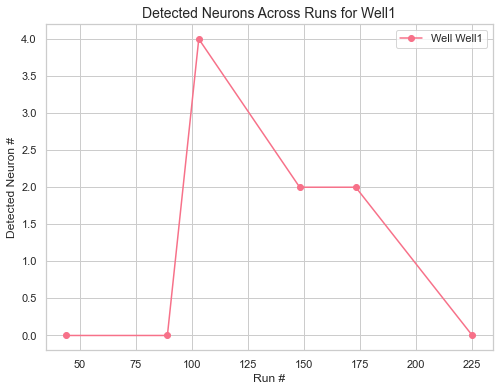

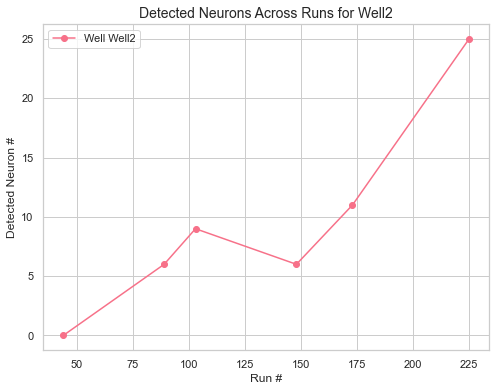

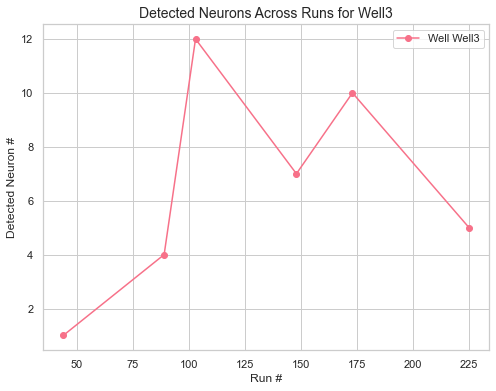

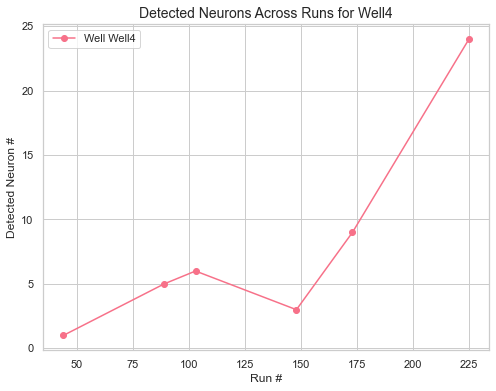

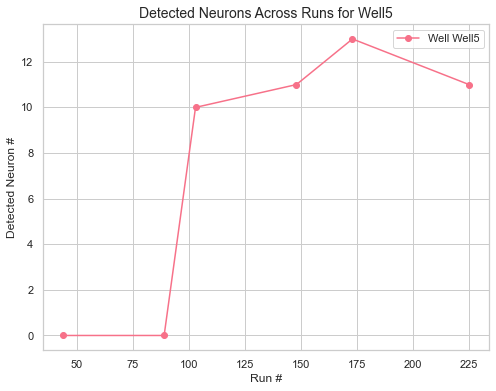

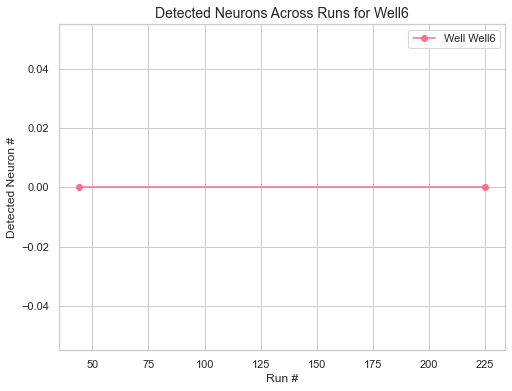

In [99]:
# Group data by 'Well #' and iterate through each well
wells = df_detection_summary["Well #"].unique()

for well in wells:
    # Filter data for the current well
    df_well = df_detection_summary[df_detection_summary["Well #"] == well]
    
    # Plot detected neuron count across runs
    plt.figure(figsize=(8, 6))
    plt.plot(df_well["Run #"], df_well["Neurons Detected"], marker='o', label=f"Well {well}")
    plt.title(f"Detected Neurons Across Runs for {well}", fontsize=14)
    plt.xlabel("Run #", fontsize=12)
    plt.ylabel("Detected Neuron #", fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.show()

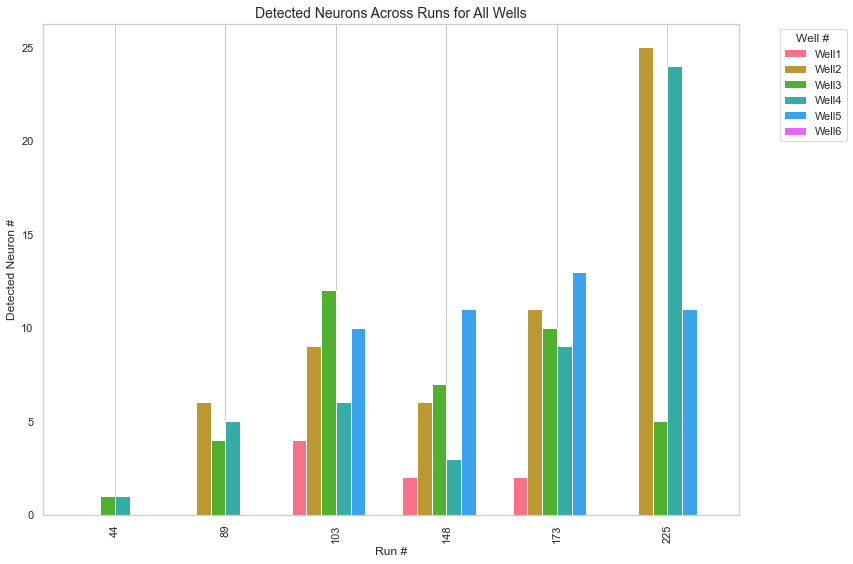

In [100]:
import numpy as np

# Pivot the data to prepare for grouped bar plot
df_pivot = df_detection_summary.pivot(index="Run #", columns="Well #", values="Neurons Detected")

# Plot grouped bar chart
df_pivot.plot(kind="bar", figsize=(12, 8), width=0.8)
plt.title("Detected Neurons Across Runs for All Wells", fontsize=14)
plt.xlabel("Run #", fontsize=12)
plt.ylabel("Detected Neuron #", fontsize=12)
plt.legend(title="Well #", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

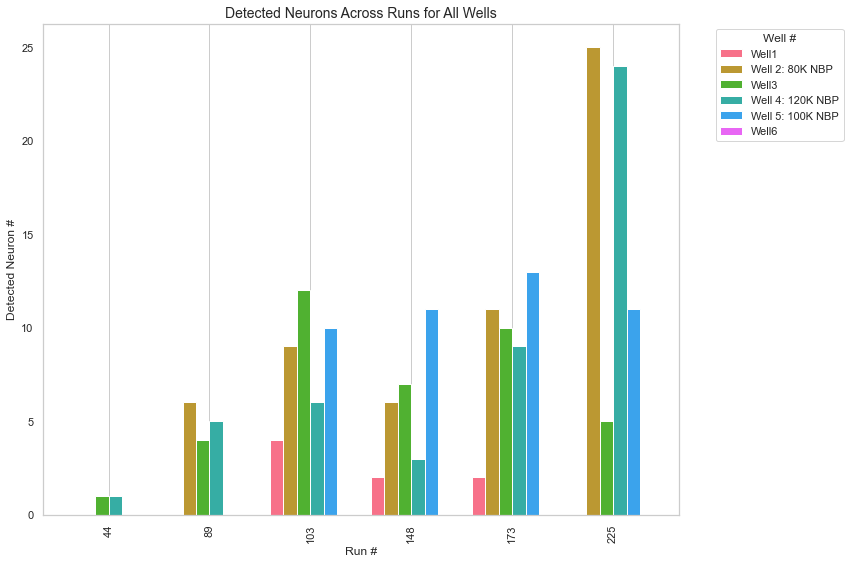

In [102]:
import numpy as np

# Pivot the data to prepare for grouped bar plot
df_pivot = df_detection_summary.pivot(index="Run #", columns="Well #", values="Neurons Detected")

# Manual well label mapping - CAN CHANGE WELL LABELS TO BE ANYTHING BASED ON YOUR EXPERIMENT
well_labels = {
    2: "Well 2: 80K NBP",
    4: "Well 4: 120K NBP", 
    5: "Well 5: 100K NBP"
}

# Create enhanced column labels
enhanced_columns = []
for col in df_pivot.columns:
    # Extract number from column name like "Well1", "Well2", etc.
    if isinstance(col, str) and col.startswith("Well"):
        well_num = int(col.replace("Well", ""))
    else:
        well_num = int(col) if not isinstance(col, str) else col
    
    if well_num in well_labels:
        enhanced_columns.append(well_labels[well_num])
    else:
        enhanced_columns.append(col)  # Keep original column name

# Update the column names
df_pivot.columns = enhanced_columns

# Plot grouped bar chart (same as your original)
df_pivot.plot(kind="bar", figsize=(12, 8), width=0.8)
plt.title("Detected Neurons Across Runs for All Wells", fontsize=14)
plt.xlabel("Run #", fontsize=12)
plt.ylabel("Detected Neuron #", fontsize=12)
plt.legend(title="Well #", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

## Rest -- plots for various metrics (i.e branch length) for deteced neurons (> 800000 um^2) 
There is some hard coded stuff, such as file paths and run numbers, but that can be replaced with desired file_path and run numbers 
for example: 

# Paths
DETECTED_CSV = "/mnt/disk15tb/shruti/output_AxonTracking_T1_08052025/axon_detected_footprints.csv"
ORIGINAL_BASE = "/mnt/ben-shalom_nas/raw_data/rbs_maxtwo_desktop/harddisk24tbvol1/Media_Density_T3_07012025_AR/Media_Density_T3_07012025_AR"
OUTPUT_BASE = "/mnt/disk15tb/shruti/output_AxonTracking_T1_08052025/DetectedPNGs"

^^ you can change these file paths to be as desired 


In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

# === Load tracking sheet (metadata) ===
metadata = pd.read_csv(metadata_file_path)
metadata["Run #"] = metadata["Run #"].astype(str)
axon_tracking_meta = metadata[metadata["Assay"] == "Axon Tracking"].copy()

# Build mapping: run_number → {well_number: "density"}
run_well_density_map = {}
for _, row in axon_tracking_meta.iterrows():
    run_num = str(row["Run #"])
    wells = str(row["Wells_Recorded"]).split(",")
    sources = str(row["Neuron Source"]).split(",")
    wells = [int(re.search(r"\d+", w).group()) for w in wells if re.search(r"\d+", w)]
    sources = [s.strip() for s in sources]
    
    mapping = {}
    for well, source in zip(wells, sources):
        density_match = re.search(r"(\d+)K", source)
        if density_match:
            mapping[well] = f"{density_match.group(1)}K"
        else:
            mapping[well] = source  # fallback
    run_well_density_map[run_num] = mapping

# === Load axon footprint data ===
df = pd.read_csv("/mnt/disk15tb/shruti/output_AxonTracking_T1_08052025/axon_detected_footprints.csv")

# Clean and prepare data
df["Run #"] = df["Run #"].astype(str)
df["Well #"] = df["Well #"].astype(str)
df["Well_Num"] = df["Well #"].str.extract(r"(\d+)").astype(int)

# Filter only detected neurons (Detection Area > 800000)
df_detected = df[df["Detection Area (µm²)"] > 800000].copy()

# === Add Density column using mapping ===
def get_density(run_num, well_num):
    mapping = run_well_density_map.get(run_num, {})
    return mapping.get(well_num, "Unknown")

df_detected["Density"] = df_detected.apply(
    lambda row: get_density(row["Run #"], row["Well_Num"]), axis=1
)

# Remove rows with Unknown density
df_detected = df_detected[df_detected["Density"] != "Unknown"]

# Sort densities numerically for consistent ordering
def extract_density_value(density_str):
    match = re.search(r"(\d+)", density_str)
    return int(match.group(1)) if match else 0

df_detected["Density_Value"] = df_detected["Density"].apply(extract_density_value)
df_detected = df_detected.sort_values("Density_Value")

# === Create plots for each run ===
for run_num, run_data in df_detected.groupby("Run #"):
    print(f"\n📊 Plotting Run: {run_num}")
    
    # Calculate mean axonal area per density
    mean_data = run_data.groupby("Density")["Detection Area (µm²)"].agg(['mean', 'count']).reset_index()
    mean_data = mean_data.sort_values("Density", key=lambda x: x.apply(extract_density_value))
    
    plt.figure(figsize=(12, 8))
    
    # Create bar plot for means
    bars = plt.bar(mean_data["Density"], mean_data["mean"], 
                   alpha=0.7, color='lightblue', edgecolor='navy', linewidth=2,
                   label='Mean Axonal Area')
    
    # Add individual neuron markers
    for density in mean_data["Density"]:
        density_data = run_data[run_data["Density"] == density]
        x_pos = list(mean_data["Density"]).index(density)
        
        # Add jitter to x-position for better visibility
        jitter = np.random.normal(0, 0.1, len(density_data))
        plt.scatter([x_pos] * len(density_data) + jitter, 
                   density_data["Detection Area (µm²)"],
                   color='red', alpha=0.6, s=40, zorder=5,
                   label='Individual Neurons' if density == mean_data["Density"].iloc[0] else "")
    
    # Add mean values as text on bars
    for i, (density, mean_val, count) in enumerate(zip(mean_data["Density"], mean_data["mean"], mean_data["count"])):
        plt.text(i, mean_val + mean_val*0.02, f'{mean_val:.0f}\n(n={count})', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Formatting
    plt.title(f"Axonal Area by Density — Run: {run_num}", fontsize=16, fontweight='bold')
    plt.xlabel("Density", fontsize=14)
    plt.ylabel("Axonal Area (µm²)", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.legend(fontsize=12)
    
    # Format y-axis to show values in a readable format
    ax = plt.gca()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Summary for Run {run_num}:")
    for _, row in mean_data.iterrows():
        print(f"  {row['Density']}: Mean = {row['mean']:.0f} µm², Count = {row['count']} neurons")

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from pathlib import Path

# === Load metadata and create density mapping ===
metadata = pd.read_csv(metadata_file_path)
metadata["Run #"] = metadata["Run #"].astype(str)
axon_tracking_meta = metadata[metadata["Assay"] == "Axon Tracking"].copy()

# Build mapping: run_number → {well_number: "density"}
run_well_density_map = {}
for _, row in axon_tracking_meta.iterrows():
    run_num = str(row["Run #"])
    wells = str(row["Wells_Recorded"]).split(",")
    sources = str(row["Neuron Source"]).split(",")
    wells = [int(re.search(r"\d+", w).group()) for w in wells if re.search(r"\d+", w)]
    sources = [s.strip() for s in sources]
    
    mapping = {}
    for well, source in zip(wells, sources):
        density_match = re.search(r"(\d+)K", source)
        if density_match:
            mapping[well] = f"{density_match.group(1)}K"
        else:
            mapping[well] = source  # fallback
    run_well_density_map[run_num] = mapping

# === Load detected neurons data ===
detected_footprints = pd.read_csv("/mnt/disk15tb/shruti/output_AxonTracking_T1_08052025/axon_detected_footprints.csv")
detected_footprints["Run #"] = detected_footprints["Run #"].astype(str)
detected_footprints["Well_Num"] = detected_footprints["Well #"].str.extract(r"(\d+)").astype(int)
detected_footprints = detected_footprints[detected_footprints["Detection Area (µm²)"] > 800000]

# Create set of detected neurons for filtering
detected_neurons = set()
for _, row in detected_footprints.iterrows():
    detected_neurons.add((str(row["Run #"]), row["Well_Num"], row["FootprintNeuron #"]))

# === Load branch length data using your directory structure ===
root_path = Path("/mnt/ben-shalom_nas/raw_data/rbs_maxtwo_desktop/harddisk24tbvol1/Media_Density_T3_07012025_AR/Media_Density_T3_07012025_AR/shruti_axontracking_analysis_detailedcsvs/")

def search_branch_data_across_runs(data_dict):
    results = []
    for run_num, file_dict in data_dict.items():
        numeric_run_num = int(re.search(r'\d+', run_num).group())
        
        # Look for branch length data in branch_metrics or similar files
        for file_name, df in file_dict.items():
            if 'branch' in file_name.lower() and 'branchLen' in df.columns:
                # Assuming there are columns for neuron ID and well
                required_cols = ['branchLen']
                
                # Try to identify neuron and well columns (adjust based on your actual column names)
                neuron_col = None
                well_col = None
                
                for col in df.columns:
                    if any(x in col.lower() for x in ['neuron', 'cell', 'id']):
                        neuron_col = col
                    if any(x in col.lower() for x in ['well']):
                        well_col = col
                
                if neuron_col and well_col:
                    for _, row in df.iterrows():
                        if pd.notna(row['branchLen']):
                            well_num = int(re.search(r'\d+', str(row[well_col])).group()) if re.search(r'\d+', str(row[well_col])) else None
                            neuron_id = row[neuron_col]
                            
                            if well_num and (str(numeric_run_num), well_num, neuron_id) in detected_neurons:
                                results.append({
                                    "run_number": numeric_run_num,
                                    "well_num": well_num,
                                    "neuron_id": neuron_id,
                                    "branch_length": row['branchLen']
                                })
    
    return pd.DataFrame(results)

# Load the data using your existing structure
data_dict = {}
for run_folder in root_path.iterdir():
    if run_folder.is_dir():
        run_number = run_folder.name.split("_")[-1]
        csv_folder = run_folder / "csv"
        if csv_folder.exists():
            run_data = {}
            for file in csv_folder.glob("*.csv"):
                key_name = file.stem
                try:
                    run_data[key_name] = pd.read_csv(file)
                except Exception as e:
                    print(f"Error reading {file.name} in run {run_number}: {e}")
            data_dict[run_number] = run_data

# Get branch length data for detected neurons
branch_data = search_branch_data_across_runs(data_dict)

if not branch_data.empty:
    # Add density information
    def get_density(run_num, well_num):
        mapping = run_well_density_map.get(str(run_num), {})
        return mapping.get(well_num, "Unknown")

    branch_data["Density"] = branch_data.apply(
        lambda row: get_density(row["run_number"], row["well_num"]), axis=1
    )
    
    # Remove unknown densities
    branch_data = branch_data[branch_data["Density"] != "Unknown"]
    
    # Calculate sum of branch lengths per neuron
    neuron_branch_sums = branch_data.groupby(['run_number', 'well_num', 'neuron_id', 'Density'])['branch_length'].sum().reset_index()
    neuron_branch_sums.rename(columns={'branch_length': 'total_branch_length'}, inplace=True)
    
    # Sort densities numerically
    def extract_density_value(density_str):
        match = re.search(r"(\d+)", density_str)
        return int(match.group(1)) if match else 0
    
    neuron_branch_sums["Density_Value"] = neuron_branch_sums["Density"].apply(extract_density_value)
    neuron_branch_sums = neuron_branch_sums.sort_values("Density_Value")
    
    # === Create plots for each run ===
    for run_num, run_data in neuron_branch_sums.groupby("run_number"):
        print(f"\n📊 Plotting Run: {run_num}")
        
        # Calculate mean total branch length per density
        mean_data = run_data.groupby("Density")["total_branch_length"].agg(['mean', 'count']).reset_index()
        mean_data = mean_data.sort_values("Density", key=lambda x: x.apply(extract_density_value))
        
        plt.figure(figsize=(12, 8))
        
        # Create bar plot for means
        bars = plt.bar(mean_data["Density"], mean_data["mean"], 
                       alpha=0.7, color='lightgreen', edgecolor='darkgreen', linewidth=2,
                       label='Mean Total Branch Length')
        
        # Add individual neuron markers
        for density in mean_data["Density"]:
            density_data = run_data[run_data["Density"] == density]
            x_pos = list(mean_data["Density"]).index(density)
            
            # Add jitter for better visibility
            jitter = np.random.normal(0, 0.1, len(density_data))
            plt.scatter([x_pos] * len(density_data) + jitter, 
                       density_data["total_branch_length"],
                       color='orange', alpha=0.6, s=40, zorder=5,
                       label='Individual Neurons' if density == mean_data["Density"].iloc[0] else "")
        
        # Add mean values as text on bars
        for i, (density, mean_val, count) in enumerate(zip(mean_data["Density"], mean_data["mean"], mean_data["count"])):
            plt.text(i, mean_val + mean_val*0.02, f'{mean_val:.0f}\n(n={count})', 
                    ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Formatting
        plt.title(f"Total Branch Length per Detected Neuron by Density — Run: {run_num}", fontsize=16, fontweight='bold')
        plt.xlabel("Density", fontsize=14)
        plt.ylabel("Total Branch Length (µm)", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        plt.legend(fontsize=12)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"Summary for Run {run_num}:")
        for _, row in mean_data.iterrows():
            print(f"  {row['Density']}: Mean Total Branch Length = {row['mean']:.0f} µm, Count = {row['count']} neurons")

else:
    print("No branch length data found. Please check column names and file structure.")
    print("Available columns in branch files:")
    for run_num, file_dict in data_dict.items():
        for file_name, df in file_dict.items():
            if 'branch' in file_name.lower():
                print(f"Run {run_num}, File {file_name}: {list(df.columns)}")

No branch length data found. Please check column names and file structure.
Available columns in branch files:
Run 44, File branch_metrics: ['Unnamed: 0', 'instance', 'neuron', 'branch', 'branchLen', 'branchConductionVel', 'conductionVelFit', 'latFromInitSite', 'distFromInitSite', 'totNoSpikes', 'neuronFiringRate', 'isiViolationRate', 'fisherProjectionDistance', 'silhouetteScore', 'spikesNoPerConfig_mean', 'completeness', 'date', 'wellplateID', 'wellNo', 'runID', 'wellGroupName', 'wellGroupColor', 'Plating Date', 'control', 'assayTag', 'div']
Run 89, File branch_metrics: ['Unnamed: 0', 'instance', 'neuron', 'branch', 'branchLen', 'branchConductionVel', 'conductionVelFit', 'latFromInitSite', 'distFromInitSite', 'totNoSpikes', 'neuronFiringRate', 'isiViolationRate', 'fisherProjectionDistance', 'silhouetteScore', 'spikesNoPerConfig_mean', 'completeness', 'date', 'wellplateID', 'wellNo', 'runID', 'wellGroupName', 'wellGroupColor', 'Plating Date', 'control', 'assayTag', 'div']
Run 103, File 

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from pathlib import Path

# === Load metadata and create density mapping ===
metadata = pd.read_csv(metadata_file_path)
metadata["Run #"] = metadata["Run #"].astype(str)
axon_tracking_meta = metadata[metadata["Assay"] == "Axon Tracking"].copy()

# Build mapping: run_number → {well_number: "density"}
run_well_density_map = {}
for _, row in axon_tracking_meta.iterrows():
    run_num = str(row["Run #"])
    wells = str(row["Wells_Recorded"]).split(",")
    sources = str(row["Neuron Source"]).split(",")
    wells = [int(re.search(r"\d+", w).group()) for w in wells if re.search(r"\d+", w)]
    sources = [s.strip() for s in sources]
    
    mapping = {}
    for well, source in zip(wells, sources):
        density_match = re.search(r"(\d+)K", source)
        if density_match:
            mapping[well] = f"{density_match.group(1)}K"
        else:
            mapping[well] = source  # fallback
    run_well_density_map[run_num] = mapping

# === Load detected neurons data ===
detected_footprints = pd.read_csv("/mnt/disk15tb/shruti/output_AxonTracking_T1_08052025/axon_detected_footprints.csv")
detected_footprints["Run #"] = detected_footprints["Run #"].astype(str)
detected_footprints["Well_Num"] = detected_footprints["Well #"].str.extract(r"(\d+)").astype(int)
detected_footprints = detected_footprints[detected_footprints["Detection Area (µm²)"] > 800000]

# Create set of detected neurons for filtering
detected_neurons = set()
for _, row in detected_footprints.iterrows():
    detected_neurons.add((str(row["Run #"]), row["Well_Num"], row["FootprintNeuron #"]))

# === Load branch length data using your directory structure ===
root_path = Path("/mnt/ben-shalom_nas/raw_data/rbs_maxtwo_desktop/harddisk24tbvol1/Media_Density_T3_07012025_AR/Media_Density_T3_07012025_AR/shruti_axontracking_analysis_detailedcsvs/")

def search_column_across_runs(data_dict, column_name):
    results = []
    for run_num, file_dict in data_dict.items():
        # Extract numeric part of run_num
        numeric_run_num = int(re.search(r'\d+', run_num).group())
        for file_name, df in file_dict.items():
            if column_name in df.columns:
                for _, row in df.iterrows():
                    if pd.notna(row[column_name]) and pd.notna(row['neuron']) and pd.notna(row['wellNo']):
                        well_num = int(row['wellNo'])
                        neuron_id = int(row['neuron'])
                        
                        # Check if this neuron is in our detected neurons set
                        if (str(numeric_run_num), well_num, neuron_id) in detected_neurons:
                            results.append({
                                "run_number": numeric_run_num,
                                "well_num": well_num, 
                                "neuron_id": neuron_id,
                                "branch_length": row[column_name]
                            })
    
    return pd.DataFrame(results)

# Load the data using your existing structure
data_dict = {}
for run_folder in root_path.iterdir():
    if run_folder.is_dir():
        run_number = run_folder.name.split("_")[-1]
        csv_folder = run_folder / "csv"
        if csv_folder.exists():
            run_data = {}
            for file in csv_folder.glob("*.csv"):
                key_name = file.stem
                try:
                    run_data[key_name] = pd.read_csv(file)
                except Exception as e:
                    print(f"Error reading {file.name} in run {run_number}: {e}")
            data_dict[run_number] = run_data

# Get branch length data for detected neurons using your original function structure
column_name = "branchLen"
branch_results = search_column_across_runs(data_dict, column_name)

if not branch_results.empty:
    # Add density information
    def get_density(run_num, well_num):
        mapping = run_well_density_map.get(str(run_num), {})
        return mapping.get(well_num, "Unknown")

    branch_results["Density"] = branch_results.apply(
        lambda row: get_density(row["run_number"], row["well_num"]), axis=1
    )
    
    # Remove unknown densities
    branch_results = branch_results[branch_results["Density"] != "Unknown"]
    
    # Convert branch_length to numeric, handling any string values
    branch_results['branch_length'] = pd.to_numeric(branch_results['branch_length'], errors='coerce')
    
    # Remove any rows where branch_length couldn't be converted to numeric
    branch_results = branch_results.dropna(subset=['branch_length'])
    
    # Calculate sum of branch lengths per neuron
    neuron_branch_sums = branch_results.groupby(['run_number', 'well_num', 'neuron_id', 'Density'])['branch_length'].sum().reset_index()
    neuron_branch_sums.rename(columns={'branch_length': 'total_branch_length'}, inplace=True)
    
    # Sort densities numerically
    def extract_density_value(density_str):
        match = re.search(r"(\d+)", density_str)
        return int(match.group(1)) if match else 0
    
    neuron_branch_sums["Density_Value"] = neuron_branch_sums["Density"].apply(extract_density_value)
    neuron_branch_sums = neuron_branch_sums.sort_values("Density_Value")
    
    # === Create plots for each run ===
    for run_num, run_data in neuron_branch_sums.groupby("run_number"):
        print(f"\n📊 Plotting Run: {run_num}")
        
        # Calculate mean total branch length per density
        mean_data = run_data.groupby("Density")["total_branch_length"].agg(['mean', 'count']).reset_index()
        mean_data = mean_data.sort_values("Density", key=lambda x: x.apply(extract_density_value))
        
        plt.figure(figsize=(12, 8))
        
        # Create bar plot for means
        bars = plt.bar(mean_data["Density"], mean_data["mean"], 
                       alpha=0.7, color='lightgreen', edgecolor='darkgreen', linewidth=2,
                       label='Mean Total Branch Length')
        
        # Add individual neuron markers
        for density in mean_data["Density"]:
            density_data = run_data[run_data["Density"] == density]
            x_pos = list(mean_data["Density"]).index(density)
            
            # Add jitter for better visibility
            jitter = np.random.normal(0, 0.1, len(density_data))
            plt.scatter([x_pos] * len(density_data) + jitter, 
                       density_data["total_branch_length"],
                       color='orange', alpha=0.6, s=40, zorder=5,
                       label='Individual Neurons' if density == mean_data["Density"].iloc[0] else "")
        
        # Add mean values as text on bars
        for i, (density, mean_val, count) in enumerate(zip(mean_data["Density"], mean_data["mean"], mean_data["count"])):
            plt.text(i, mean_val + mean_val*0.02, f'{mean_val:.0f}\n(n={count})', 
                    ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Formatting
        plt.title(f"Total Branch Length per Detected Neuron by Density — Run: {run_num}", fontsize=16, fontweight='bold')
        plt.xlabel("Density", fontsize=14)
        plt.ylabel("Total Branch Length (µm)", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        plt.legend(fontsize=12)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"Summary for Run {run_num}:")
        for _, row in mean_data.iterrows():
            print(f"  {row['Density']}: Mean Total Branch Length = {row['mean']:.0f} µm, Count = {row['count']} neurons")

else:
    print("No branch length data found. Please check column names and file structure.")
    print("Available columns in branch files:")
    for run_num, file_dict in data_dict.items():
        for file_name, df in file_dict.items():
            if 'branch' in file_name.lower():
                print(f"Run {run_num}, File {file_name}: {list(df.columns)}")

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from pathlib import Path

# === Load metadata and create density mapping ===
metadata = pd.read_csv(metadata_file_path)
metadata["Run #"] = metadata["Run #"].astype(str)
axon_tracking_meta = metadata[metadata["Assay"] == "Axon Tracking"].copy()

# Build mapping: run_number → {well_number: "density"}
run_well_density_map = {}
for _, row in axon_tracking_meta.iterrows():
    run_num = str(row["Run #"])
    wells = str(row["Wells_Recorded"]).split(",")
    sources = str(row["Neuron Source"]).split(",")
    wells = [int(re.search(r"\d+", w).group()) for w in wells if re.search(r"\d+", w)]
    sources = [s.strip() for s in sources]
    
    mapping = {}
    for well, source in zip(wells, sources):
        density_match = re.search(r"(\d+)K", source)
        if density_match:
            mapping[well] = f"{density_match.group(1)}K"
        else:
            mapping[well] = source  # fallback
    run_well_density_map[run_num] = mapping

# === Load detected neurons data ===
detected_footprints = pd.read_csv("/mnt/disk15tb/shruti/output_AxonTracking_T1_08052025/axon_detected_footprints.csv")
detected_footprints["Run #"] = detected_footprints["Run #"].astype(str)
detected_footprints["Well_Num"] = detected_footprints["Well #"].str.extract(r"(\d+)").astype(int)
detected_footprints = detected_footprints[detected_footprints["Detection Area (µm²)"] > 800000]

# Create set of detected neurons for filtering
detected_neurons = set()
for _, row in detected_footprints.iterrows():
    detected_neurons.add((str(row["Run #"]), row["Well_Num"], row["FootprintNeuron #"]))

# === Load branch data using your directory structure ===
root_path = Path("/mnt/ben-shalom_nas/raw_data/rbs_maxtwo_desktop/harddisk24tbvol1/Media_Density_T3_07012025_AR/Media_Density_T3_07012025_AR/shruti_axontracking_analysis_detailedcsvs/")

data_dict = {}
for run_folder in root_path.iterdir():
    if run_folder.is_dir():
        run_number = run_folder.name.split("_")[-1]
        csv_folder = run_folder / "csv"
        if csv_folder.exists():
            run_data = {}
            for file in csv_folder.glob("*.csv"):
                key_name = file.stem
                try:
                    run_data[key_name] = pd.read_csv(file)
                except Exception as e:
                    print(f"Error reading {file.name} in run {run_number}: {e}")
            data_dict[run_number] = run_data

# Function to count branches per detected neuron
def count_branches_per_neuron(data_dict):
    results = []
    for run_num, file_dict in data_dict.items():
        # Extract numeric part of run_num
        numeric_run_num = int(re.search(r'\d+', run_num).group())
        
        # Look for branch_metrics file
        if 'branch_metrics' in file_dict:
            df = file_dict['branch_metrics']
            
            # Count occurrences of each neuron (each row = one branch)
            for _, row in df.iterrows():
                if pd.notna(row['neuron']) and pd.notna(row['wellNo']):
                    well_num = int(row['wellNo'])
                    neuron_id = int(row['neuron'])
                    
                    # Check if this neuron is in our detected neurons set
                    if (str(numeric_run_num), well_num, neuron_id) in detected_neurons:
                        results.append({
                            "run_number": numeric_run_num,
                            "well_num": well_num,
                            "neuron_id": neuron_id
                        })
    
    return pd.DataFrame(results)

# Get branch count data
branch_count_data = count_branches_per_neuron(data_dict)

if not branch_count_data.empty:
    # Count branches per neuron (each row represents one branch)
    neuron_branch_counts = branch_count_data.groupby(['run_number', 'well_num', 'neuron_id']).size().reset_index(name='branch_count')
    
    # Add density information
    def get_density(run_num, well_num):
        mapping = run_well_density_map.get(str(run_num), {})
        return mapping.get(well_num, "Unknown")

    neuron_branch_counts["Density"] = neuron_branch_counts.apply(
        lambda row: get_density(row["run_number"], row["well_num"]), axis=1
    )
    
    # Remove unknown densities
    neuron_branch_counts = neuron_branch_counts[neuron_branch_counts["Density"] != "Unknown"]
    
    # Sort densities numerically
    def extract_density_value(density_str):
        match = re.search(r"(\d+)", density_str)
        return int(match.group(1)) if match else 0
    
    neuron_branch_counts["Density_Value"] = neuron_branch_counts["Density"].apply(extract_density_value)
    neuron_branch_counts = neuron_branch_counts.sort_values("Density_Value")
    
    # === Create plots for each run ===
    for run_num, run_data in neuron_branch_counts.groupby("run_number"):
        print(f"\n📊 Plotting Run: {run_num}")
        
        # Calculate mean branch count per density
        mean_data = run_data.groupby("Density")["branch_count"].agg(['mean', 'count']).reset_index()
        mean_data = mean_data.sort_values("Density", key=lambda x: x.apply(extract_density_value))
        
        plt.figure(figsize=(12, 8))
        
        # Create bar plot for means
        bars = plt.bar(mean_data["Density"], mean_data["mean"], 
                       alpha=0.7, color='lightcoral', edgecolor='darkred', linewidth=2,
                       label='Mean Branch Count')
        
        # Add individual neuron markers
        for density in mean_data["Density"]:
            density_data = run_data[run_data["Density"] == density]
            x_pos = list(mean_data["Density"]).index(density)
            
            # Add jitter for better visibility
            jitter = np.random.normal(0, 0.1, len(density_data))
            plt.scatter([x_pos] * len(density_data) + jitter, 
                       density_data["branch_count"],
                       color='blue', alpha=0.6, s=40, zorder=5,
                       label='Individual Neurons' if density == mean_data["Density"].iloc[0] else "")
        
        # Add mean values as text on bars
        for i, (density, mean_val, count) in enumerate(zip(mean_data["Density"], mean_data["mean"], mean_data["count"])):
            plt.text(i, mean_val + mean_val*0.02, f'{mean_val:.1f}\n(n={count})', 
                    ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Formatting
        plt.title(f"Number of Branches per Detected Neuron by Density — Run: {run_num}", fontsize=16, fontweight='bold')
        plt.xlabel("Density", fontsize=14)
        plt.ylabel("Number of Branches per Neuron", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        plt.legend(fontsize=12)
        
        # Set y-axis to start from 0 for better comparison
        plt.ylim(bottom=0)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"Summary for Run {run_num}:")
        for _, row in mean_data.iterrows():
            print(f"  {row['Density']}: Mean Branches = {row['mean']:.1f}, Count = {row['count']} neurons")

else:
    print("No branch data found for detected neurons.")
    print("Check that the run numbers match between your branch_metrics files and detected footprints.")

In [108]:
import os
import shutil
import pandas as pd

# Paths
DETECTED_CSV = "/mnt/disk15tb/shruti/output_AxonTracking_T1_08052025/axon_detected_footprints.csv"
ORIGINAL_BASE = "/mnt/ben-shalom_nas/raw_data/rbs_maxtwo_desktop/harddisk24tbvol1/Media_Density_T3_07012025_AR/Media_Density_T3_07012025_AR"
OUTPUT_BASE = "/mnt/disk15tb/shruti/output_AxonTracking_T1_08052025/DetectedPNGs"

# Load CSV
df = pd.read_csv(DETECTED_CSV)

# Debug: Print first few rows to understand the data structure
print("First few rows of detected footprints:")
print(df.head())
print(f"\nColumn names: {df.columns.tolist()}")
print(f"Data types:\n{df.dtypes}")

# Clean the data - handle the Run # formatting
df["Run #"] = df["Run #"].astype(str)
original_run_numbers = df["Run #"].unique()
print(f"\nOriginal run numbers: {original_run_numbers}")

# Try both with and without zero-padding for run numbers
df["Run #"] = df["Run #"].str.zfill(6)
padded_run_numbers = df["Run #"].unique()
print(f"Padded run numbers: {padded_run_numbers}")

# Build multiple search patterns to handle different file naming conventions
detected_patterns = []
for _, row in df.iterrows():
    run_num = row["Run #"]
    well = row["Well #"]
    neuron_num = row["FootprintNeuron #"]
    
    # Try different filename patterns
    patterns = [
        f"FootprintNeuron#{neuron_num}.png",
        f"FootprintNeuron{neuron_num}.png", 
        f"Neuron#{neuron_num}.png",
        f"Neuron{neuron_num}.png",
        f"footprint_{neuron_num}.png",
        f"footprint_neuron_{neuron_num}.png"
    ]
    
    for pattern in patterns:
        detected_patterns.append((run_num, well, pattern, neuron_num))

print(f"\nTotal search patterns created: {len(detected_patterns)}")

# Also try original run numbers (without padding)
for _, row in df.iterrows():
    run_num = str(row["Run #"]).lstrip('0')  # Remove leading zeros
    if run_num == '':  # Handle case where run number was all zeros
        run_num = '0'
    well = row["Well #"]
    neuron_num = row["FootprintNeuron #"]
    
    patterns = [
        f"FootprintNeuron#{neuron_num}.png",
        f"FootprintNeuron{neuron_num}.png"
    ]
    
    for pattern in patterns:
        detected_patterns.append((run_num, well, pattern, neuron_num))

missing = []
found = 0
found_files = []

print(f"\nSearching in: {ORIGINAL_BASE}")
print("Sample directory structure check...")

# First, let's explore the directory structure
sample_dirs = []
for root, dirs, files in os.walk(ORIGINAL_BASE):
    if len(sample_dirs) < 10:  # Just get first 10 directories for debugging
        sample_dirs.append(root)
    if len(sample_dirs) >= 10:
        break

print("Sample directory paths:")
for i, dir_path in enumerate(sample_dirs[:5]):
    print(f"  {i+1}: {dir_path}")

# Walk all files in the directory
print("\nSearching for PNG files...")
all_png_files = []

for root, dirs, files in os.walk(ORIGINAL_BASE):
    for file in files:
        if file.endswith(".png") and ("footprint" in file.lower() or "neuron" in file.lower()):
            full_path = os.path.join(root, file)
            all_png_files.append((root, file))
            
            # Extract Run and Well from path
            parts = root.split(os.sep)
            
            # Try to find run number in path (look for 6-digit numbers, then shorter ones)
            run_candidates = [p for p in parts if p.isdigit()]
            run_id = None
            
            # First try 6-digit numbers
            six_digit = [p for p in run_candidates if len(p) == 6]
            if six_digit:
                run_id = six_digit[0]
            elif run_candidates:
                # Try other digit lengths
                run_id = max(run_candidates, key=len)  # Take the longest digit string
            
            # Find well identifier
            well = next((p for p in parts if p.lower().startswith("well")), None)
            
            if run_id and well:
                # Check against all our patterns
                for pattern_run, pattern_well, pattern_file, neuron_num in detected_patterns:
                    if (run_id == pattern_run and well == pattern_well and file == pattern_file):
                        # Create destination directory
                        dst_dir = os.path.join(OUTPUT_BASE, f"Run{run_id}", well)
                        os.makedirs(dst_dir, exist_ok=True)
                        
                        # Create new filename with more info
                        new_filename = f"Run{run_id}_{well}_Neuron{neuron_num}_{file}"
                        dst_path = os.path.join(dst_dir, new_filename)
                        
                        try:
                            shutil.copy2(full_path, dst_path)
                            found += 1
                            found_files.append((run_id, well, file, neuron_num))
                            print(f"✅ Copied: {file} -> {new_filename} in {dst_dir}")
                        except Exception as e:
                            print(f"❌ Error copying {file}: {e}")
                        break

print(f"\nTotal PNG files found in directory: {len(all_png_files)}")
print(f"✅ Total PNGs copied: {found}")

# Show some examples of PNG files found
print(f"\nFirst 10 PNG files found:")
for i, (root, file) in enumerate(all_png_files[:10]):
    print(f"  {i+1}: {file} in {root}")

# Create summary of what was found vs what was expected
expected_neurons = set((row["Run #"], row["Well #"], row["FootprintNeuron #"]) for _, row in df.iterrows())
found_neurons = set((run_id, well, neuron_num) for run_id, well, file, neuron_num in found_files)

print(f"\nExpected neurons: {len(expected_neurons)}")
print(f"Found neurons: {len(found_neurons)}")

# Find missing ones
missing_neurons = expected_neurons - found_neurons
if missing_neurons:
    print(f"\nMissing {len(missing_neurons)} neurons:")
    missing_df = pd.DataFrame(list(missing_neurons), columns=["Run #", "Well #", "FootprintNeuron #"])
    missing_df.to_csv("/mnt/disk15tb/shruti/output_AxonTracking_T1_08052025/missing_detailed.csv", index=False)
    print("Detailed missing list saved to missing_detailed.csv")
    
    # Show first few missing
    for i, (run_id, well, neuron_num) in enumerate(list(missing_neurons)[:5]):
        print(f"  Missing: Run {run_id}, {well}, Neuron {neuron_num}")

# Save found files summary
if found_files:
    found_df = pd.DataFrame(found_files, columns=["Run #", "Well #", "Original_Filename", "FootprintNeuron #"])
    found_df.to_csv("/mnt/disk15tb/shruti/output_AxonTracking_T1_08052025/successfully_copied.csv", index=False)
    print("Successfully copied files list saved to successfully_copied.csv")

First few rows of detected footprints:
   Run # Well #  FootprintNeuron # Detected  Detection Area (µm²)
0     44  Well3                 13      Yes             815925.93
1     44  Well4                 15      Yes            1186635.80
2     89  Well2                  1      Yes            1023549.38
3     89  Well2                 11      Yes             860524.69
4     89  Well2                 18      Yes             860123.46

Column names: ['Run #', 'Well #', 'FootprintNeuron #', 'Detected', 'Detection Area (µm²)']
Data types:
Run #                     int64
Well #                   object
FootprintNeuron #         int64
Detected                 object
Detection Area (µm²)    float64
dtype: object

Original run numbers: ['44' '89' '103' '148' '173' '225']
Padded run numbers: ['000044' '000089' '000103' '000148' '000173' '000225']

Total search patterns created: 1182

Searching in: /mnt/ben-shalom_nas/raw_data/rbs_maxtwo_desktop/harddisk24tbvol1/Media_Density_T3_07012025_AR/Media_

### REST IS STILL IN PROGRESS

In [ ]:
import os
import shutil
import pandas as pd

# Paths
DETECTED_CSV = "/mnt/disk15tb/shruti/output_AxonTracking_T1_08052025/axon_detected_footprints.csv"
ORIGINAL_BASE = "/mnt/ben-shalom_nas/raw_data/rbs_maxtwo_desktop/harddisk24tbvol1/Media_Density_T3_07012025_AR/Media_Density_T3_07012025_AR"
OUTPUT_BASE = "/mnt/disk15tb/shruti/output_AxonTracking_T1_08052025/DetectedPNGs"

# Load CSV
df = pd.read_csv(DETECTED_CSV)
df["Run #"] = df["Run #"].astype(str).str.zfill(6)

# Build dictionary for fast lookup
detected_set = set(
    (row["Run #"], row["Well #"], f"FootprintNeuron#{row['FootprintNeuron #']}.png")
    for _, row in df.iterrows()
)

missing = []
found = 0

# Walk all files in the directory
for root, _, files in os.walk(ORIGINAL_BASE):
    for file in files:
        if file.startswith("FootprintNeuron#") and file.endswith(".png"):
            full_path = os.path.join(root, file)

            # Extract Run and Well from path
            parts = root.split(os.sep)
            try:
                run_idx = next(i for i, p in enumerate(parts) if p.isdigit() and len(p) == 6)
                run_id = parts[run_idx]
                well = next((p for p in parts if p.startswith("Well")), None)
            except StopIteration:
                continue  # skip malformed paths

            # Is this file in our detection CSV?
            key = (run_id, well, file)
            if key in detected_set:
                dst_dir = os.path.join(OUTPUT_BASE, f"Run{run_id}", well)
                os.makedirs(dst_dir, exist_ok=True)
                dst_path = os.path.join(dst_dir, file)
                shutil.copy2(full_path, dst_path)
                found += 1
                print(f"✅ Copied: {file} to {dst_dir}")
                detected_set.remove(key)

# Any that weren't found
for run_id, well, file in detected_set:
    missing.append((run_id, well, file))
    print(f"⚠️ Still missing: Run {run_id}, {well}, {file}")

# Save missing list
pd.DataFrame(missing, columns=["Run #", "Well #", "Filename"]).to_csv(
    "/mnt/disk15tb/shruti/output_AxonTracking_T1_08052025/missing_detected_pngs_updated.csv", index=False
)

print(f"\n✅ Total PNGs copied: {found}")
print(f"📄 Missing list saved as: missing_detected_pngs_updated.csv")


In [ ]:
import os
import shutil
import pandas as pd

# Paths
DETECTED_CSV = "/mnt/disk15tb/shruti/output_AxonTracking_T1_08052025/axon_detected_footprints.csv"
ORIGINAL_BASE = "/mnt/ben-shalom_nas/raw_data/rbs_maxtwo_desktop/harddisk24tbvol1/Media_Density_T3_07012025_AR/Media_Density_T3_07012025_AR"
OUTPUT_BASE = "/mnt/disk15tb/shruti/output_AxonTracking_T1_08052025/DetectedPNGs"

# Load CSV and filter rows where Detected == "Yes"
df = pd.read_csv(DETECTED_CSV)
df = df[df["Detected"] == "Yes"]  # Filter only rows with Detected == "Yes"
df["Run #"] = df["Run #"].astype(str).str.zfill(6)  # Ensure Run # is zero-padded to 6 digits

# Build a set for fast lookup
detected_set = set(
    (row["Run #"], row["Well #"].strip(), f"FootprintNeuron#{int(row['FootprintNeuron #'])}.png")
    for _, row in df.iterrows()
)

missing = []
found = 0

# Walk through all files in the directory
for root, _, files in os.walk(ORIGINAL_BASE):
    for file in files:
        if file.startswith("FootprintNeuron#") and file.endswith(".png"):
            full_path = os.path.join(root, file)

            # Extract Run and Well from the path
            parts = root.split(os.sep)
            try:
                # Extract Run ID (6-digit folder)
                run_idx = next(i for i, p in enumerate(parts) if p.isdigit() and len(p) == 6)
                run_id = parts[run_idx].zfill(6)  # Ensure zero-padding

                # Extract Well (folder starting with "Well")
                well = next((p for p in parts if p.startswith("Well")), None)
                if well is None:
                    continue  # Skip if Well is not found

                # Normalize Well and File
                well = well.strip()
                file = file.strip()

                # Check if this file is in our detection set
                key = (run_id, well, file)
                if key in detected_set:
                    dst_dir = os.path.join(OUTPUT_BASE, f"Run{run_id}", well)
                    os.makedirs(dst_dir, exist_ok=True)
                    dst_path = os.path.join(dst_dir, file)
                    shutil.copy2(full_path, dst_path)
                    found += 1
                    print(f"✅ Copied: {file} to {dst_dir}")
                    detected_set.remove(key)
            except StopIteration:
                continue  # Skip malformed paths

# Handle any files that weren't found
for run_id, well, file in detected_set:
    missing.append((run_id, well, file))
    print(f"⚠️ Still missing: Run {run_id}, {well}, {file}")

# Save the missing list to a CSV file
missing_csv_path = "/mnt/disk15tb/shruti/output_AxonTracking_T1_08052025/missing_detected_pngs_updated.csv"
pd.DataFrame(missing, columns=["Run #", "Well #", "Filename"]).to_csv(missing_csv_path, index=False)

print(f"\n✅ Total PNGs copied: {found}")
print(f"📄 Missing list saved as: {missing_csv_path}")

In [ ]:
print(f"Searching for: Run {run_id}, Well {well}, File {file}")
print(f"Detected Set: {key in detected_set}")